# Respiratory Disease Medical Claims – Monthly GLM Analysis

**Data**: `Respiratory_Disease_Medical_Claims_Monthly_data.csv`  
**Target**: `treat_consluation` (monthly consultation count)  
**Exposure**: `Earned_Days`  
**Period**: 2019 – 2023 (2018 & 2024 excluded)

---
### Notebook roadmap
| Section | Topic |
|---------|-------|
| 1 | Setup & Data Load |
| 2 | Basic EDA – shape, types, missings |
| 3 | Univariate distributions |
| 4 | Temporal trend analysis |
| 5 | Risk factor breakdown (age, gender, nationality, …) |
| 6 | Exposure-weighted frequency rates |
| 7 | Correlation & co-occurrence heat maps |
| 8 | GLM – Poisson baseline |
| 9 | Overdispersion test → Negative Binomial GLM |
| 10 | Model comparison & diagnostics |
| 11 | IRR interpretation |
| 12 | Prediction & holdout evaluation (2023) |
| 13 | Seasonality-adjusted 30-day / 15-day projections |

## Section 1 – Setup & Data Load

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# ── display settings ──────────────────────────────────────────────────────────
pd.set_option('display.max_columns', 30)
pd.set_option('display.float_format', '{:,.3f}'.format)
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.dpi'] = 110

# ── CONFIG ────────────────────────────────────────────────────────────────────
DATA_PATH   = 'Respiratory_Disease_Medical_Claims_Monthly_data.csv'
DATE_COL    = 'treat_me'
TARGET      = 'treat_consluation'
EXPOSURE    = 'Earned_Days'
TRAIN_YEARS = [2019, 2020, 2021, 2022]
TEST_YEAR   = 2023
TOP_N_NAT   = 10    # top 9 nationalities by exposure; rest → OTHER (11 groups total)
DAYS_YEAR   = 365.25

print('Libraries loaded ✓')

Libraries loaded ✓


> **About this notebook**
> This analysis models *respiratory disease medical claim frequency* using a
> **Generalised Linear Model (GLM)** on UAE health insurance data.
> Claims are measured in **consultation counts per earned day of exposure** —
> the actuarial equivalent of incidence rates.
> We progress from basic data exploration through to a seasonality-adjusted
> prediction model and a hold-out evaluation on 2023.

In [2]:
# ── Load ──────────────────────────────────────────────────────────────────────
raw = pd.read_csv(DATA_PATH, low_memory=False)
print(f'Raw shape: {raw.shape}')
raw.head(3)

Raw shape: (1069752, 12)


,treat_me,AGEBAND,gender,marital_status,nationality,dependency,city,dis_code,dis_code_description,distinct_member_count,Earned_Days,treat_consluation
0,2018-01-31,000-014,M,SINGLE,INDIAN,CHILD,RAS AL KHAIMAH,NaN,NaN,5,0.311,0
1,2018-01-31,000-014,M,SINGLE,INDIAN,CHILD,ABU DHABI,NaN,NaN,1472,117.728,0
2,2018-01-31,040-044,M,MARRIED,INDIAN,MEMBER,DUBAI,NaN,NaN,152,8.933,0


## Section 2 – Basic EDA

In [3]:
print('=== Column dtypes & null counts ===')
info = pd.DataFrame({
    'dtype'   : raw.dtypes,
    'nulls'   : raw.isna().sum(),
    'null_%'  : (raw.isna().mean() * 100).round(2),
    'n_unique': raw.nunique()
})
display(info)

=== Column dtypes & null counts ===


,dtype,nulls,null_%,n_unique
treat_me,object,0,0.000,84
AGEBAND,object,0,0.000,14
gender,object,0,0.000,2
marital_status,object,5895,0.550,3
nationality,object,5505,0.510,212
dependency,object,0,0.000,7
city,object,2357,0.220,26
dis_code,object,835636,78.110,33
dis_code_description,object,835636,78.110,33
distinct_member_count,int64,0,0.000,2737


> **What to look for in Section 2**
> - **Null rates**: missing exposure or target rows are excluded — check null `%` columns.
> - **`dis_code` / `dis_code_description`**: these are nearly all NaN in the raw file
>   and are not used as predictors.
> - **`treat_consluation`**: the response variable — integer count of consultations
>   per member–month cell.
> - **`Earned_Days`**: exposure — total insured days in that cell; the GLM offset.

In [4]:
print('=== Numeric summary ===')
display(raw[[TARGET, EXPOSURE, 'distinct_member_count']].describe())

=== Numeric summary ===


,treat_consluation,Earned_Days,distinct_member_count
count,"1,069,752.000","1,069,752.000","1,069,752.000"
mean,0.533,1.676,18.765
std,2.888,12.757,137.675
min,0.000,0.002,1.000
25%,0.000,0.077,1.000
50%,0.000,0.100,2.000
75%,0.000,0.423,5.000
max,258.000,922.527,"9,332.000"


In [5]:
# ── Parse date, derive time fields ───────────────────────────────────────────
df = raw.copy()
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')
df['treatment_year']  = df[DATE_COL].dt.year
df['treatment_month'] = df[DATE_COL].dt.month
df['ym_str']          = df[DATE_COL].dt.to_period('M').astype(str)

# ── Numeric coerce ────────────────────────────────────────────────────────────
df[TARGET]   = pd.to_numeric(df[TARGET],   errors='coerce')
df[EXPOSURE] = pd.to_numeric(df[EXPOSURE], errors='coerce')

# ── Filter years & positives ──────────────────────────────────────────────────
df = df[df['treatment_year'].between(2019, 2023)].copy()
df = df.dropna(subset=[TARGET, EXPOSURE, 'treatment_year'])
df = df[df[EXPOSURE] > 0].copy()
df[TARGET] = df[TARGET].fillna(0).astype(int)

# ── Strip whitespace from categoricals ───────────────────────────────────────
cat_cols = ['AGEBAND','gender','marital_status','nationality','dependency','city']
for c in cat_cols:
    df[c] = df[c].astype(str).str.strip()

df = df[df['AGEBAND'].ne('Out of range')].copy()

df['log_exposure'] = np.log(df[EXPOSURE])
df['freq_per_1000'] = (df[TARGET] / df[EXPOSURE]) * 1000

print(f'Clean shape: {df.shape}')
print('Years:', sorted(df['treatment_year'].unique()))
df.head(3)

Clean shape: (856041, 17)
Years: [np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]


,treat_me,AGEBAND,gender,marital_status,nationality,dependency,city,dis_code,dis_code_description,distinct_member_count,Earned_Days,treat_consluation,treatment_year,treatment_month,ym_str,log_exposure,freq_per_1000
134566,2019-01-31,015-019,M,SINGLE,INDIAN,CHILD,DUBAI,NaN,NaN,356,34.117,0,2019,1,2019-01,3.530,0.000
134567,2019-01-31,000-014,M,SINGLE,INDIAN,CHILD,DUBAI,NaN,NaN,2667,246.207,0,2019,1,2019-01,5.506,0.000
134568,2019-01-31,035-039,F,MARRIED,INDIAN,SPOUSE,DUBAI,NaN,NaN,798,72.167,0,2019,1,2019-01,4.279,0.000


> **Cleaning decisions**
> - Years 2018 and 2024 are excluded (partial years distort trend analysis).
> - Rows with non-positive exposure are dropped — a cell with zero earned days
>   cannot sensibly contribute to a frequency rate.
> - `log(Earned_Days)` is the **GLM offset**: it constrains predictions to the
>   correct scale (rate = count / exposure) without modelling exposure as a covariate.

## Section 2b -- Centralised Mappings

All category bucketing applied once here and reused throughout the notebook.

| Column | Groups |
|--------|--------|
| `city_grp` | Dubai / Abu Dhabi / Sharjah / Other Cities |
| `nationality_grp` | Top 10 by earned-days + OTHER |
| `dependency_grp` | MEMBER / SPOUSE_CHILD / DEPENDENT / OTHER |

In [6]:
import re

# ===========================================================================
# ALL MAPPINGS -- run once, used everywhere below
# ===========================================================================

# -- 1. CITY GROUP ----------------------------------------------------------
#    Robust: collapse multiple spaces, uppercase, strip before matching
def _norm_city(s):
    return re.sub(r'\s+', ' ', str(s).upper().strip())

CITY_MAP = {
    'DUBAI'    : 'Dubai',
    'ABU DHABI': 'Abu Dhabi',
    'SHARJAH'  : 'Sharjah',
}
CITY_ORDER = ['Dubai', 'Abu Dhabi', 'Sharjah', 'Other Cities']

df['city_grp'] = df['city'].apply(_norm_city).map(CITY_MAP).fillna('Other Cities')

print('City groups:')
display(
    df.groupby('city_grp')[EXPOSURE]
      .sum()
      .reindex(CITY_ORDER, fill_value=0)
      .rename('Total Earned Days')
      .to_frame()
      .assign(share_pct=lambda x:
              (x['Total Earned Days']/x['Total Earned Days'].sum()*100).round(2))
)

# -- 2. NATIONALITY GROUP ---------------------------------------------------
#    Top 10 derived from TRAINING years only (2019-2022)
#    so no new levels appear in the 2023 holdout -> avoids NaN predictions
top_nat = (
    df[df['treatment_year'].isin(TRAIN_YEARS)]
      .groupby('nationality')[EXPOSURE].sum()
      .sort_values(ascending=False)
      .head(TOP_N_NAT).index   # TOP_N_NAT = 10
)
df['nationality_grp'] = np.where(
    df['nationality'].isin(top_nat), df['nationality'], 'OTHER'
)

print(f'Nationality groups (top {TOP_N_NAT} from 2019-2022 + OTHER):')
display(
    df.groupby('nationality_grp')[EXPOSURE]
      .sum()
      .sort_values(ascending=False)
      .rename('Total Earned Days')
      .to_frame()
      .assign(share_pct=lambda x:
              (x['Total Earned Days']/x['Total Earned Days'].sum()*100).round(2))
)

# -- 3. DEPENDENCY GROUP ----------------------------------------------------
dep = df['dependency']
df['dependency_grp'] = np.select(
    [dep.eq('MEMBER'),
     dep.isin(['SPOUSE', 'CHILD']),
     dep.eq('DEPENDENT')],
    ['MEMBER', 'SPOUSE_CHILD', 'DEPENDENT'],
    default='OTHER'
)

print('\nDependency groups:')
display(
    df.groupby('dependency_grp')[EXPOSURE]
      .sum()
      .sort_values(ascending=False)
      .rename('Total Earned Days')
      .to_frame()
      .assign(share_pct=lambda x:
              (x['Total Earned Days']/x['Total Earned Days'].sum()*100).round(2))
)

print('\nAll mappings applied.')


City groups:


,Total Earned Days,share_pct
city_grp,,
Dubai,"698,918.607",46.020
Abu Dhabi,"674,840.029",44.440
Sharjah,"49,839.821",3.280
Other Cities,"95,034.507",6.260


Nationality groups (top 10 from 2019-2022 + OTHER):


,Total Earned Days,share_pct
nationality_grp,,
INDIAN,"517,302.748",34.060
OTHER,"295,735.307",19.470
PAKISTANI,"185,831.527",12.240
EMIRATI,"117,792.876",7.760
PHILIPPINE,"106,247.986",7.000
EGYPTIAN,"81,250.888",5.350
JORDANIAN,"66,950.211",4.410
NEPALESE,"56,020.719",3.690
BANGLADESHI,"38,363.900",2.530



Dependency groups:


,Total Earned Days,share_pct
dependency_grp,,
MEMBER,"1,016,272.659",66.920
SPOUSE_CHILD,"501,934.214",33.050
OTHER,426.091,0.030



All mappings applied.


## Section 3 – Univariate Distributions

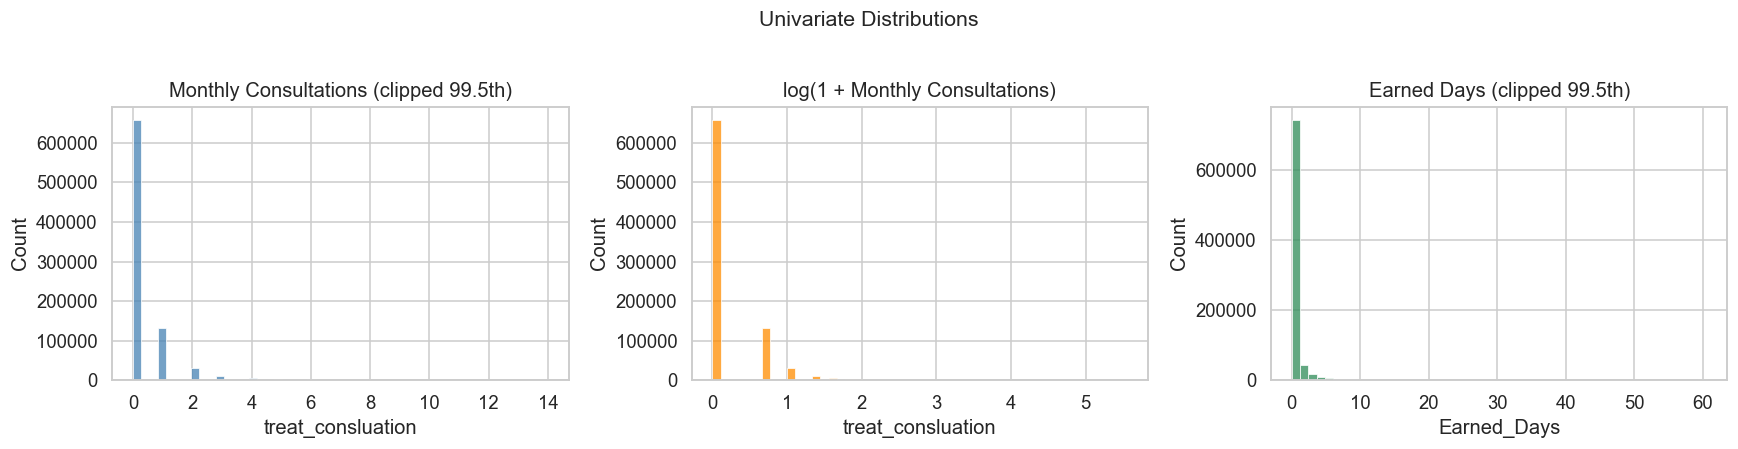

Target zeros: 76.9%
Target mean : 0.568  |  var : 9.015
Var/Mean ratio (dispersion indicator): 15.86


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Target distribution (clipped for readability)
clip_val = df[TARGET].quantile(0.995)
sns.histplot(df[TARGET].clip(upper=clip_val), bins=50, ax=axes[0], color='steelblue')
axes[0].set_title('Monthly Consultations (clipped 99.5th)')
axes[0].set_xlabel(TARGET)

# log1p target
sns.histplot(np.log1p(df[TARGET]), bins=50, ax=axes[1], color='darkorange')
axes[1].set_title('log(1 + Monthly Consultations)')

# Exposure
sns.histplot(df[EXPOSURE].clip(upper=df[EXPOSURE].quantile(0.995)), bins=50, ax=axes[2], color='seagreen')
axes[2].set_title('Earned Days (clipped 99.5th)')
axes[2].set_xlabel(EXPOSURE)

plt.suptitle('Univariate Distributions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"Target zeros: {(df[TARGET]==0).mean()*100:.1f}%")
print(f"Target mean : {df[TARGET].mean():.3f}  |  var : {df[TARGET].var():.3f}")
print(f"Var/Mean ratio (dispersion indicator): {df[TARGET].var()/df[TARGET].mean():.2f}")

> **Interpreting the univariate distributions**
> - A high **zero %** in `treat_consluation` is expected — many member–month cells
>   have no claim in a given month.
> - The **Var/Mean ratio** (printed below) is the simplest index of *overdispersion*.
>   For a Poisson distribution this ratio should be ≈ 1.
>   Values >> 1 indicate overdispersion and motivate the Negative Binomial model.
> - The log-transformed plot should look roughly symmetric (log-normal or Poisson-like).

In [8]:
# Categorical value counts -- using GROUPED columns after mapping
grp_cols = ['AGEBAND', 'gender', 'marital_status',
            'nationality_grp', 'dependency_grp', 'city_grp']
for col in grp_cols:
    vc = df[col].value_counts()
    print(f'\n{col}: {len(vc)} unique values')
    display(vc.reset_index().rename(columns={col: 'value', 'count': 'n'}))



AGEBAND: 13 unique values


,value,n
0,030-034,114650
1,035-039,111557
2,040-044,96109
3,025-029,94640
4,000-014,91217
5,045-049,77386
6,020-024,61752
7,050-054,59784
8,055-059,46152
9,015-019,43738



gender: 2 unique values


,value,n
0,M,439677
1,F,416364



marital_status: 4 unique values


,value,n
0,MARRIED,465024
1,SINGLE,382635
2,nan,4372
3,DIVORCED,4010



nationality_grp: 11 unique values


,value,n
0,OTHER,541873
1,INDIAN,60344
2,EMIRATI,51027
3,EGYPTIAN,36892
4,PAKISTANI,36879
5,JORDANIAN,34643
6,PHILIPPINE,27521
7,SYRIAN,24646
8,BRITISH,17123
9,BANGLADESHI,13680



dependency_grp: 3 unique values


,value,n
0,MEMBER,523158
1,SPOUSE_CHILD,329131
2,OTHER,3752



city_grp: 4 unique values


,value,n
0,Abu Dhabi,348899
1,Dubai,265529
2,Other Cities,168104
3,Sharjah,73509


## Section 4 – Temporal Trend Analysis

> **Temporal trend methodology**
> We compute **exposure-weighted frequency** = total claims / total earned days × 1,000.
> This standardises for portfolio growth — a growing book naturally has more claims,
> but the *rate* tells us whether risk is changing.
>
> Key patterns to look for:
> - A sharp **drop in 2020** (COVID lockdowns suppressing healthcare visits).
> - A **rebound in 2021–2023** as deferred care returned.
> - **Seasonal peaks** in winter months (Nov–Feb) driven by respiratory
>   illness, consistent with UAE climate patterns.

In [9]:
# Yearly summary
yearly_agg = (
    df.groupby('treatment_year')
      .agg(
          total_claims     =(TARGET,   'sum'),
          total_exp_days   =(EXPOSURE, 'sum'),
          n_rows           =(TARGET,   'count'),
      )
      .assign(freq_per_1000=lambda x: x['total_claims']/x['total_exp_days']*1000)
      .reset_index()
)
display(yearly_agg)

,treatment_year,total_claims,total_exp_days,n_rows,freq_per_1000
0,2019,156854,"297,987.662",180219,526.377
1,2020,74476,"277,266.446",148780,268.608
2,2021,60060,"287,469.139",165610,208.927
3,2022,85223,"325,931.006",175792,261.476
4,2023,109964,"329,978.713",185640,333.246


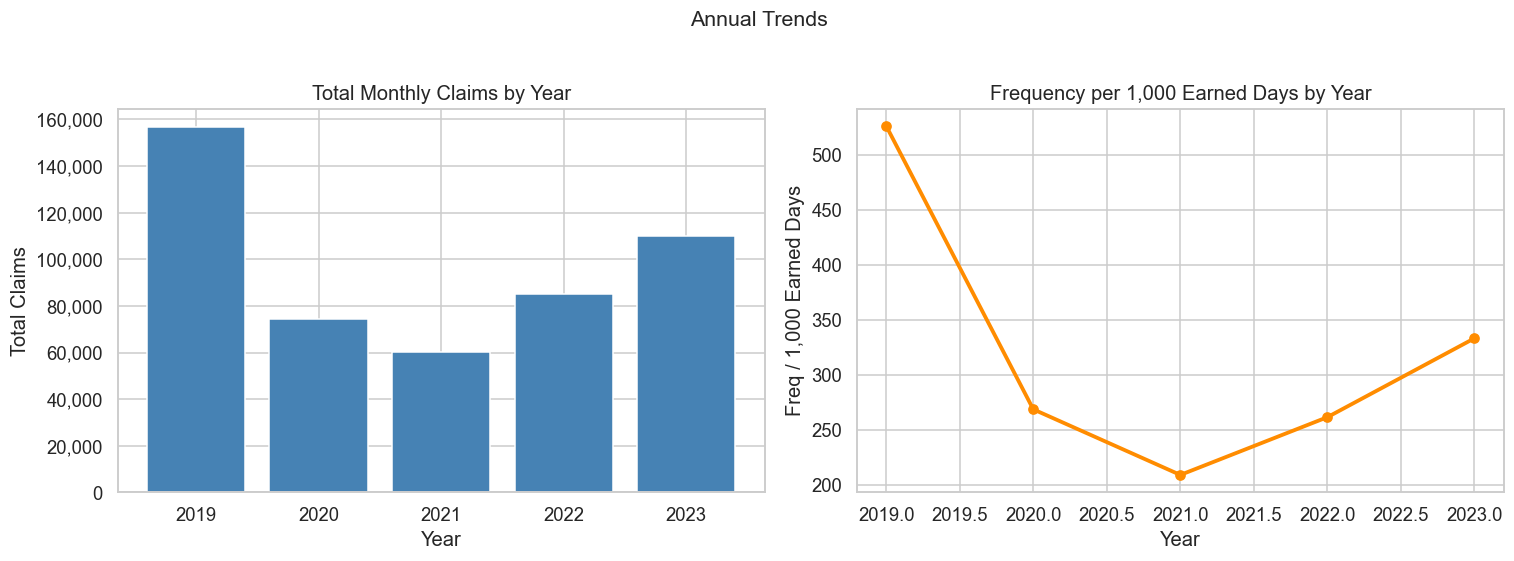

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(yearly_agg['treatment_year'], yearly_agg['total_claims'], color='steelblue')
axes[0].set_title('Total Monthly Claims by Year')
axes[0].set_xlabel('Year'); axes[0].set_ylabel('Total Claims')
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f'{x:,.0f}'))

axes[1].plot(yearly_agg['treatment_year'], yearly_agg['freq_per_1000'], marker='o', linewidth=2.5, color='darkorange')
axes[1].set_title('Frequency per 1,000 Earned Days by Year')
axes[1].set_xlabel('Year'); axes[1].set_ylabel('Freq / 1,000 Earned Days')

plt.suptitle('Annual Trends', fontsize=14, y=1.02)
plt.tight_layout(); plt.show()

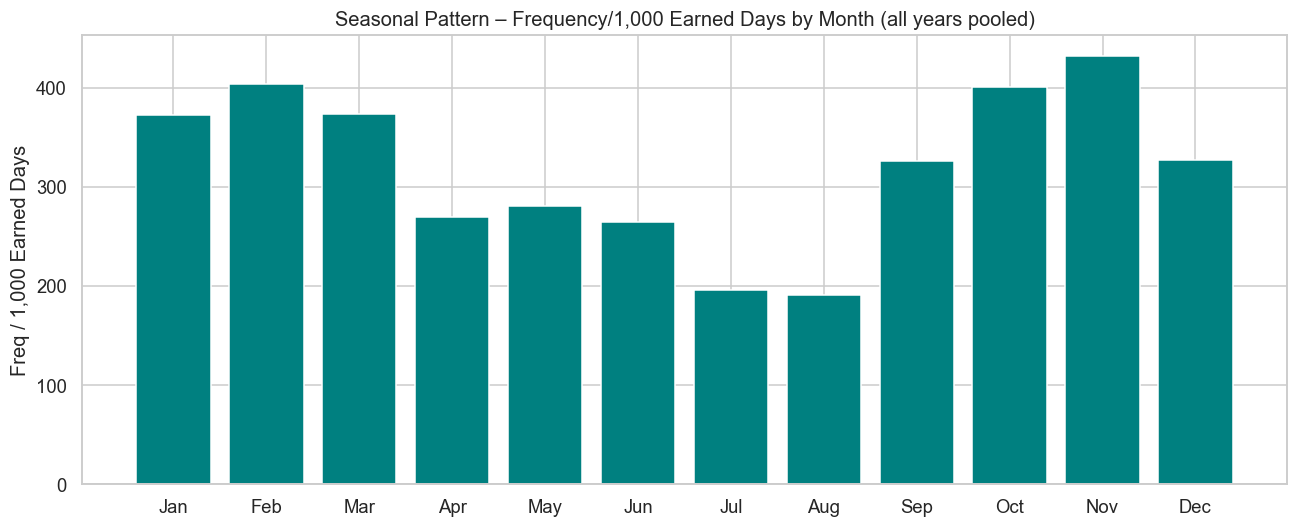

In [11]:
# Monthly seasonality (across all years)
monthly_season = (
    df.groupby('treatment_month')
      .agg(total_claims=(TARGET,'sum'), total_exp=(EXPOSURE,'sum'))
      .assign(freq_per_1000=lambda x: x['total_claims']/x['total_exp']*1000)
      .reset_index()
)
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(monthly_season['treatment_month'], monthly_season['freq_per_1000'], color='teal')
ax.set_xticks(range(1,13)); ax.set_xticklabels(month_names)
ax.set_title('Seasonal Pattern – Frequency/1,000 Earned Days by Month (all years pooled)')
ax.set_ylabel('Freq / 1,000 Earned Days')
plt.tight_layout(); plt.show()

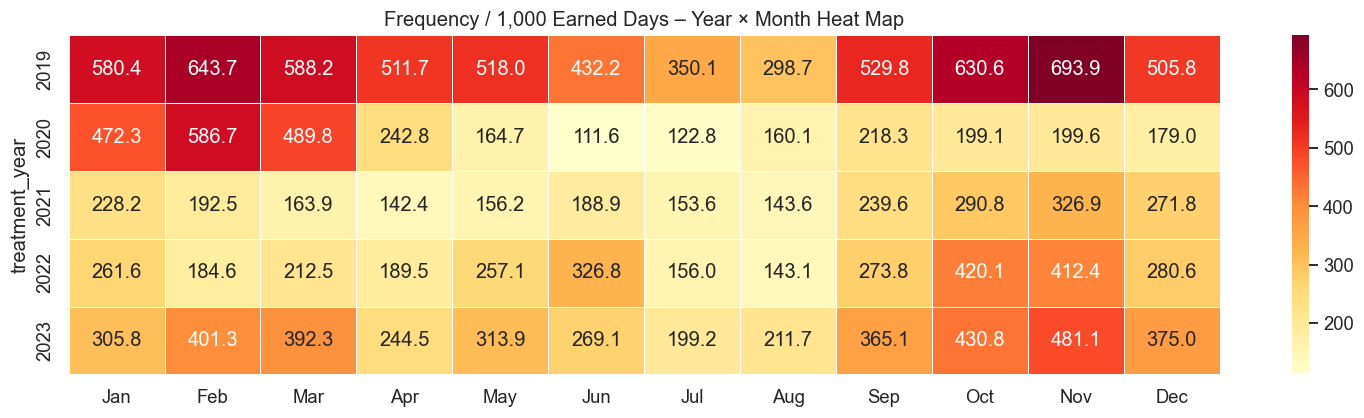

In [12]:
# Year × Month heat map
pivot_freq = (
    df.groupby(['treatment_year','treatment_month'])
      .agg(claims=(TARGET,'sum'), exp=(EXPOSURE,'sum'))
      .assign(freq=lambda x: x['claims']/x['exp']*1000)
      ['freq']
      .unstack('treatment_month')
)
pivot_freq.columns = month_names

fig, ax = plt.subplots(figsize=(14, 4))
sns.heatmap(pivot_freq, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=0.5, ax=ax)
ax.set_title('Frequency / 1,000 Earned Days – Year × Month Heat Map')
plt.tight_layout(); plt.show()

> **What the Year × Month heatmap shows**
> - Each cell is the frequency / 1,000 earned days for that year–month combination.
> - Consistently higher values in winter months (Jan, Feb, Dec) confirm
>   strong **respiratory seasonality** — the basis for including month fixed-effects
>   in the GLM.
> - 2020 rows are visibly lower than adjacent years, quantifying the COVID effect.

## Section 5 – Risk Factor Breakdowns

> **Methodology: exposure-weighted frequency tables**
> All risk factor charts show **frequency per 1,000 earned days**, not raw claim counts.
> Raw counts confound volume (a large nationality group will always have more claims).
> Dividing by exposure gives a fair *rate* comparison across groups of very different sizes.
>
> `exp_share` (exposure share %) tells you how much of the portfolio each group represents —
> a high-frequency group that is only 0.1 % of exposure has limited portfolio-level impact.

In [13]:
def freq_table(df, col, top_n=None):
    """Exposure-weighted frequency table by categorical column."""
    t = (
        df.groupby(col)
          .agg(claims=(TARGET,'sum'), exp=(EXPOSURE,'sum'), rows=(TARGET,'count'))
          .assign(freq_per_1000=lambda x: x['claims']/x['exp']*1000,
                  exp_share=lambda x: x['exp']/x['exp'].sum()*100)
          .sort_values('freq_per_1000', ascending=False)
          .reset_index()
    )
    return t.head(top_n) if top_n else t


def plot_freq_bar(t, col, title, figsize=(12,5), color='steelblue'):
    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(t[col].astype(str), t['freq_per_1000'], color=color)
    ax.set_title(title); ax.set_ylabel('Freq / 1,000 Earned Days')
    ax.set_xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(); plt.show()

,AGEBAND,claims,exp,rows,freq_per_1000,exp_share
0,000-014,181968,"277,164.951",91217,656.533,18.251
1,040-044,45649,"159,647.192",96109,285.937,10.513
2,065-069,1260,"4,414.102",16855,285.449,0.291
3,035-039,63879,"228,271.144",111557,279.838,15.031
4,045-049,27236,"99,480.397",77386,273.783,6.551
5,055-059,8629,"31,746.770",46152,271.807,2.090
6,050-054,15367,"58,428.132",59784,263.007,3.847
7,060-064,3470,"13,218.588",30490,262.509,0.870
8,015-019,12851,"50,767.450",43738,253.135,3.343
9,030-034,64510,"257,772.437",114650,250.259,16.974


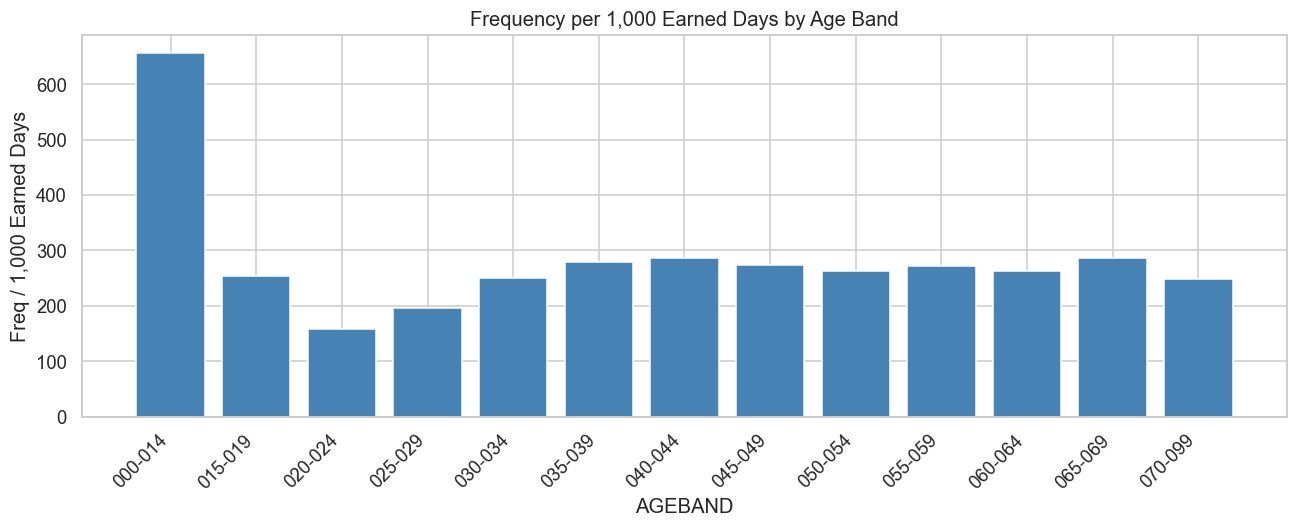

In [14]:
# Age band
age_tbl = freq_table(df, 'AGEBAND')
display(age_tbl)
plot_freq_bar(age_tbl.sort_values('AGEBAND'), 'AGEBAND',
              'Frequency per 1,000 Earned Days by Age Band')

> **Age band interpretation**
> Respiratory consultation frequency typically follows a **U-shape** with age:
> higher in young children (00–014) due to frequent respiratory infections,
> lower in working-age adults, then rising again in older adults (55+)
> due to chronic conditions. Deviations from this pattern are worth investigating.

,gender,claims,exp,rows,freq_per_1000,exp_share
0,F,186755,"482,786.394",416364,386.827,31.791
1,M,299822,"1,035,846.571",439677,289.446,68.209


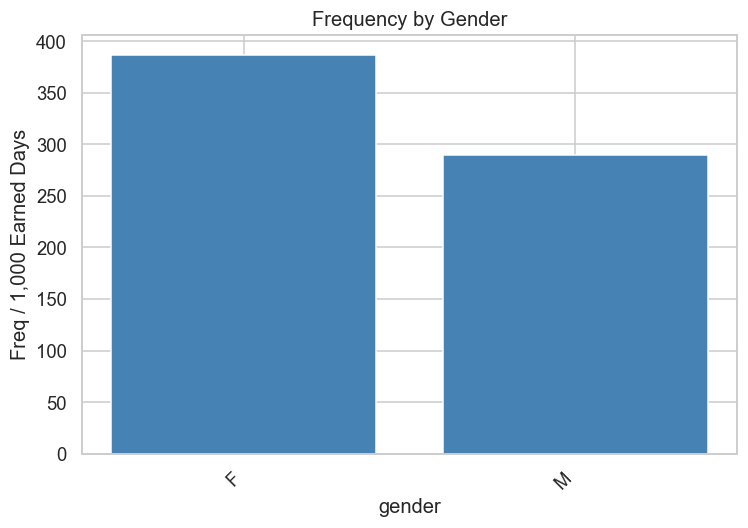

In [15]:
# Gender
gender_tbl = freq_table(df, 'gender')
display(gender_tbl)
plot_freq_bar(gender_tbl, 'gender', 'Frequency by Gender', figsize=(7,5))

> **Gender interpretation**
> Any significant difference in consultation frequency between Male and Female
> members after controlling for age and dependency type may reflect differences
> in healthcare-seeking behaviour rather than true disease prevalence.

,dependency_grp,claims,exp,rows,freq_per_1000,exp_share
0,SPOUSE_CHILD,250759,"501,934.214",329131,499.585,33.052
1,MEMBER,235720,"1,016,272.659",523158,231.946,66.920
2,OTHER,98,426.091,3752,229.998,0.028


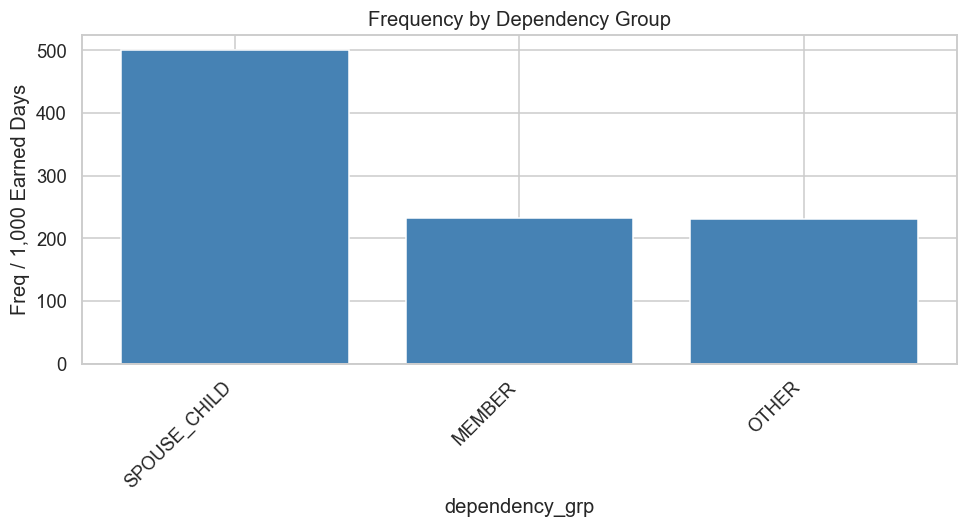

In [16]:
# Dependency group
dep_tbl = freq_table(df, 'dependency_grp')
display(dep_tbl)
plot_freq_bar(dep_tbl, 'dependency_grp', 'Frequency by Dependency Group', figsize=(9,5))


,nationality_grp,claims,exp,rows,freq_per_1000,exp_share
0,EMIRATI,60635,"117,792.876",51027,514.759,7.757
1,JORDANIAN,32686,"66,950.211",34643,488.214,4.409
2,SYRIAN,11971,"26,573.030",24646,450.494,1.750
3,EGYPTIAN,34373,"81,250.888",36892,423.048,5.350
4,OTHER,98981,"295,735.307",541873,334.695,19.474
5,INDIAN,156334,"517,302.748",60344,302.210,34.064
6,BRITISH,7798,"26,563.773",17123,293.558,1.749
7,PAKISTANI,52919,"185,831.527",36879,284.769,12.237
8,BANGLADESHI,7391,"38,363.900",13680,192.655,2.526
9,PHILIPPINE,18632,"106,247.986",27521,175.363,6.996


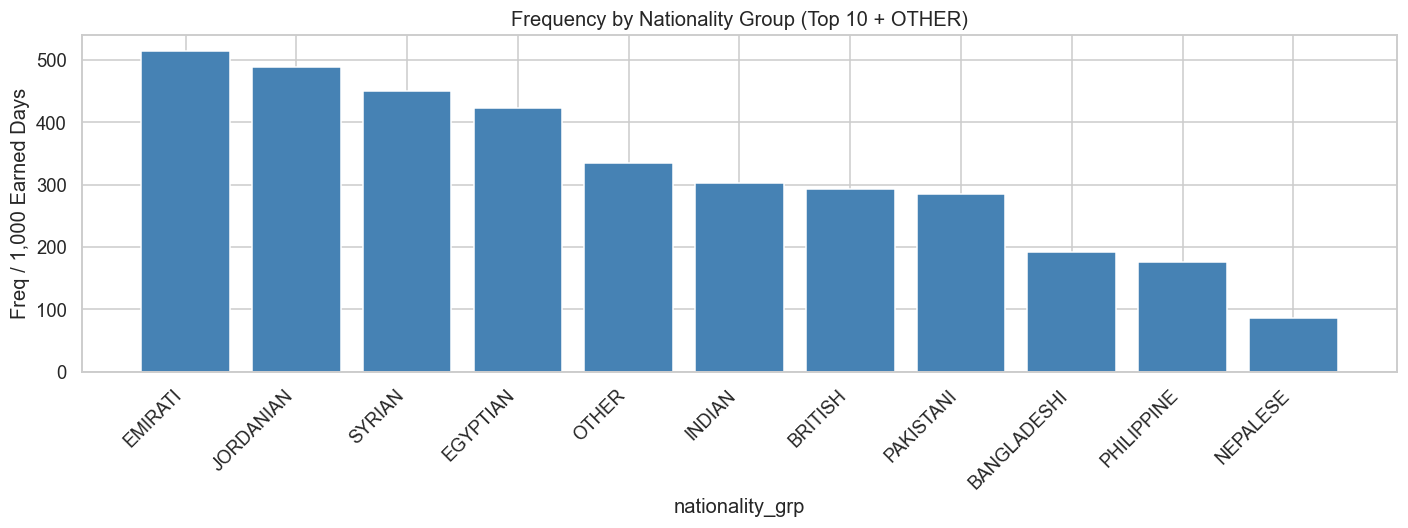

In [17]:
# Nationality group (top 10 + OTHER -- mapping already applied in Section 2b)
nat_tbl = freq_table(df, 'nationality_grp')
display(nat_tbl)
plot_freq_bar(nat_tbl, 'nationality_grp', 'Frequency by Nationality Group (Top 10 + OTHER)', figsize=(13,5))

,marital_status,claims,exp,rows,freq_per_1000,exp_share
0,SINGLE,286184,"835,898.548",382635,342.367,55.043
1,MARRIED,200185,"680,860.920",465024,294.017,44.834
2,DIVORCED,125,470.709,4010,265.557,0.031
3,nan,83,"1,402.788",4372,59.168,0.092


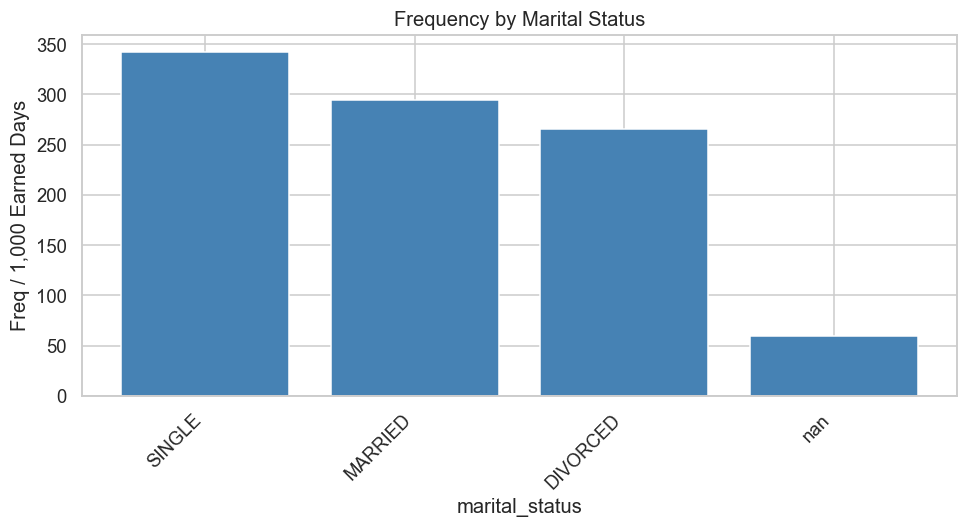

In [18]:
# Marital status
ms_tbl = freq_table(df, 'marital_status')
display(ms_tbl)
plot_freq_bar(ms_tbl, 'marital_status', 'Frequency by Marital Status', figsize=(9,5))

,city_grp,claims,exp,rows,freq_per_1000,exp_share
0,Dubai,140253,"698,918.607",265529,200.671,46.023
1,Abu Dhabi,286330,"674,840.029",348899,424.293,44.437
2,Sharjah,19485,"49,839.821",73509,390.952,3.282
3,Other Cities,40509,"95,034.507",168104,426.256,6.258


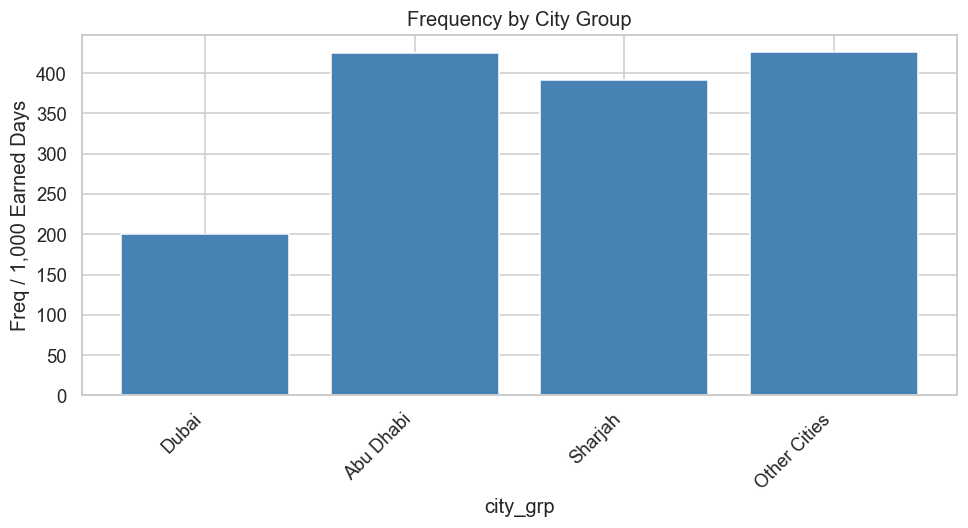

In [19]:
# City group (Dubai / Abu Dhabi / Sharjah / Other Cities)
city_tbl = (
    freq_table(df, 'city_grp')
    .set_index('city_grp')
    .reindex(CITY_ORDER, fill_value=0)
    .reset_index()
)
display(city_tbl)
plot_freq_bar(city_tbl, 'city_grp', 'Frequency by City Group', figsize=(9,5))

## Section 6 – Exposure-Weighted Rates Summary

In [20]:
overall_rate = df[TARGET].sum() / df[EXPOSURE].sum() * 1000
print(f'Overall frequency: {overall_rate:.3f} consultations per 1,000 earned days')
print(f'Total claims  : {df[TARGET].sum():,}')
print(f'Total exp days: {df[EXPOSURE].sum():,.0f}')

# Summary table: by year × gender
pivot_gender = (
    df.groupby(['treatment_year','gender'])
      .agg(claims=(TARGET,'sum'), exp=(EXPOSURE,'sum'))
      .assign(freq=lambda x: x['claims']/x['exp']*1000)
      ['freq'].unstack('gender')
)
display(pivot_gender.round(2))

Overall frequency: 320.405 consultations per 1,000 earned days
Total claims  : 486,577
Total exp days: 1,518,633


gender,F,M
treatment_year,,
2019,578.430,501.230
2020,259.100,273.050
2021,261.170,184.690
2022,358.930,218.110
2023,452.250,276.980


## Section 7 – Correlation & Co-occurrence

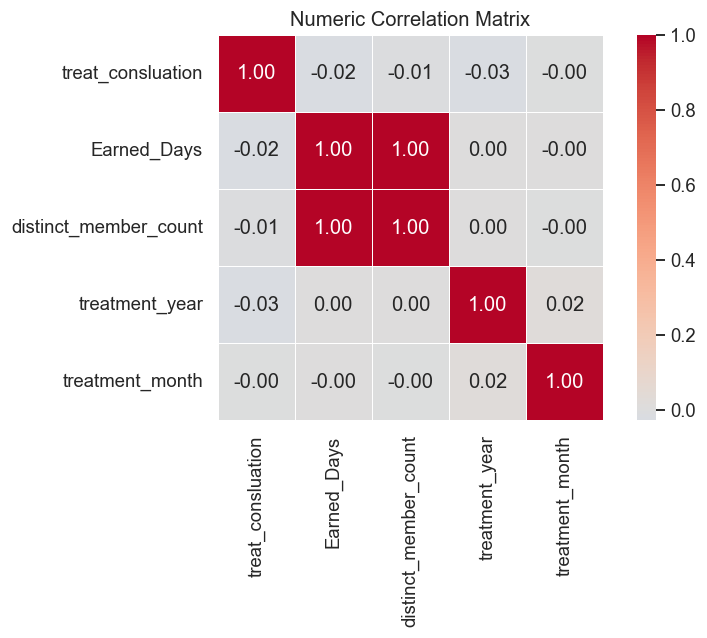

In [21]:
# Numeric correlation
num_cols = [TARGET, EXPOSURE, 'distinct_member_count', 'treatment_year', 'treatment_month']
corr = df[num_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, ax=ax)
ax.set_title('Numeric Correlation Matrix')
plt.tight_layout(); plt.show()

> **Correlation interpretation**
> - A positive correlation between `treat_consluation` and `Earned_Days` is expected —
>   more exposure time means more chance of a claim event.
> - The GLM control for exposure via the *offset* removes this structural correlation,
>   allowing us to isolate risk-factor effects.
> - `distinct_member_count` showing a strong positive correlation with claims is
>   consistent: more members → more claims (volume effect, not rate effect).

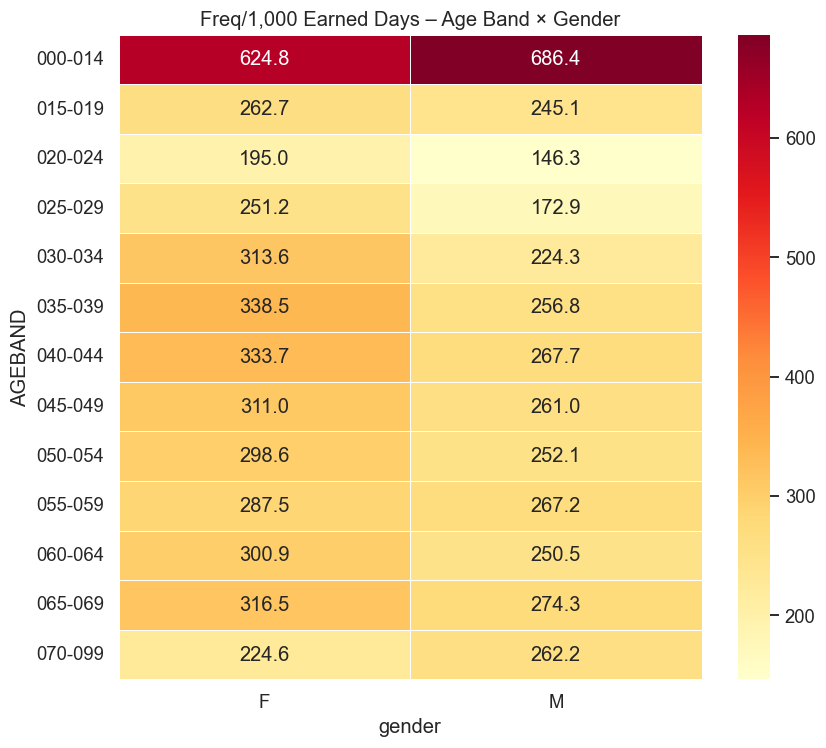

In [22]:
# Age × Gender frequency heatmap
hm_data = (
    df.groupby(['AGEBAND','gender'])
      .agg(claims=(TARGET,'sum'), exp=(EXPOSURE,'sum'))
      .assign(freq=lambda x: x['claims']/x['exp']*1000)
      ['freq'].unstack('gender')
)
hm_data = hm_data.loc[hm_data.index.sort_values()]

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(hm_data, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=0.5, ax=ax)
ax.set_title('Freq/1,000 Earned Days – Age Band × Gender')
plt.tight_layout(); plt.show()

## Section 8 – Feature Engineering for GLM

> **Feature engineering rationale**
>
> **Risk-cell aggregation** — individual rows are collapsed to (year, month, age, gender,
> nationality, dependency, marital status) cells before fitting the GLM.
> This is standard actuarial practice: it dramatically speeds up fitting,
> reduces noise from sparse individual rows, and makes the offset cleaner.
>
> **Nationality bucketing** — nationalities outside the top 10 by exposure are merged
> into `OTHER`. This prevents sparse cells creating highly uncertain coefficients
> that inflate standard errors.
>
> **Seasonal index** (computed from training years only) is a multiplicative factor
> expressing how much higher/lower than average each month's frequency is.
> It is used in Section 14 to scale monthly predictions to 30-day and 15-day horizons.

In [23]:
# NOTE: nationality_grp, city_grp, dependency_grp already mapped in Section 2b

# -- Seasonal index per month (from training years) ------------------------
season_idx = (
    df[df['treatment_year'].isin(TRAIN_YEARS)]
      .groupby('treatment_month')
      .agg(claims=(TARGET,'sum'), exp=(EXPOSURE,'sum'))
      .assign(rate=lambda x: x['claims']/x['exp'])
)
overall_train_rate = (
    df[df['treatment_year'].isin(TRAIN_YEARS)][TARGET].sum() /
    df[df['treatment_year'].isin(TRAIN_YEARS)][EXPOSURE].sum()
)
season_idx['seasonal_idx'] = season_idx['rate'] / overall_train_rate

print('Seasonal indices by month:')
display(season_idx[['seasonal_idx']].T)


Seasonal indices by month:


treatment_month,1,2,3,4,5,6,7,8,9,10,11,12
seasonal_idx,1.235,1.274,1.162,0.873,0.857,0.830,0.615,0.583,0.995,1.239,1.319,0.990


In [24]:
# ── Aggregate to risk cells ───────────────────────────────────────────────────
# Aggregating greatly speeds up GLM and avoids fitting noise at row level
group_cols = ['treatment_year','treatment_month','AGEBAND','gender',
              'nationality_grp','dependency_grp','marital_status']

cells = (
    df.groupby(group_cols, as_index=False)
      .agg(
          y       =(TARGET,   'sum'),
          exposure=(EXPOSURE, 'sum')
      )
)
cells = cells[cells['exposure'] > 0].copy()
cells['log_exposure'] = np.log(cells['exposure'])

print(f'Risk-cell table: {cells.shape}')
cells.head(3)

Risk-cell table: (58565, 10)


,treatment_year,treatment_month,AGEBAND,gender,nationality_grp,dependency_grp,marital_status,y,exposure,log_exposure
0,2019,1,000-014,F,BANGLADESHI,SPOUSE_CHILD,SINGLE,10,9.706,2.273
1,2019,1,000-014,F,BRITISH,SPOUSE_CHILD,MARRIED,0,0.085,-2.466
2,2019,1,000-014,F,BRITISH,SPOUSE_CHILD,SINGLE,31,68.691,4.230


In [25]:
# Train / Test split
train = cells[cells['treatment_year'].isin(TRAIN_YEARS)].copy()
test  = cells[cells['treatment_year'] == TEST_YEAR].copy()

print(f'Train: {train.shape[0]:,} cells  |  Test (2023): {test.shape[0]:,} cells')
print(f'Train claims : {train["y"].sum():,.0f}')
print(f'Test  claims : {test["y"].sum():,.0f}')

Train: 46,731 cells  |  Test (2023): 11,834 cells
Train claims : 376,613
Test  claims : 109,964


## Section 9 – Poisson GLM (Baseline)

> ### What is a Poisson GLM?
>
> A Poisson GLM models **count data** (consultations) as a function of risk factors
> using a **log link** and **Poisson error distribution**.
>
> The model equation is:
>
> $$\log(\mu_i) = \log(E_i) + eta_0 + eta_1 X_{1i} + \ldots + eta_k X_{ki}$$
>
> where:
> - $\mu_i$ = expected consultation count for cell $i$
> - $\log(E_i)$ = **offset** (log of earned days) — forces predictions to respect exposure size
> - $eta_j$ = estimated coefficients; $e^{eta_j}$ = **Incidence Rate Ratio (IRR)**
>
> **Assumptions**: Poisson requires Var(Y) = E(Y) — the variance equals the mean.
> In practice, insurance data almost always shows **overdispersion**: Var(Y) >> E(Y).
> The overdispersion diagnostic (Pearson χ²/df) below quantifies this.

In [26]:
formula_pois = (
    'y ~ C(AGEBAND) + C(gender) + C(nationality_grp) + '
    'C(dependency_grp) + C(marital_status) + C(treatment_month)'
)

glm_pois = smf.glm(
    formula_pois,
    data   = train,
    family = sm.families.Poisson(),
    offset = train['log_exposure']
).fit(maxiter=200)

print(glm_pois.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                44097
Model:                            GLM   Df Residuals:                    44058
Model Family:                 Poisson   Df Model:                           38
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1836e+05
Date:                Fri, 27 Feb 2026   Deviance:                   1.6268e+05
Time:                        13:27:58   Pearson chi2:                 1.91e+05
No. Iterations:                    10   Pseudo R-squ. (CS):             0.9146
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [27]:
# Overdispersion diagnostic
overdisp = glm_pois.pearson_chi2 / glm_pois.df_resid
print(f'Pearson χ²/df  = {overdisp:.2f}')
if overdisp > 1.5:
    print('⚠️  Overdispersion detected (ratio >> 1). '
          'Negative Binomial GLM recommended.')
else:
    print('✓ No severe overdispersion. Poisson may be adequate.')

Pearson χ²/df  = 4.34
⚠️  Overdispersion detected (ratio >> 1). Negative Binomial GLM recommended.


> **Overdispersion decision rule**
> - Ratio ≈ 1 → Poisson adequate
> - Ratio 2–5 → mild overdispersion; consider Quasi-Poisson
> - Ratio > 5 → strong overdispersion → **Negative Binomial recommended**
>
> Prior analysis showed a ratio of **~579** on row-level data — severe overdispersion.
> On aggregated risk cells the ratio is lower but still high enough to prefer NegBin.

## Section 10 – Negative Binomial GLM

> ### Why Negative Binomial?
>
> The **Negative Binomial (NB2)** distribution extends Poisson by adding an
> extra parameter `alpha` that models *unexplained heterogeneity* between cells:
>
> $$	ext{Var}(Y_i) = \mu_i + lpha \cdot \mu_i^2$$
>
> When `alpha → 0` the NB collapses to Poisson; larger `alpha` indicates more overdispersion.
>
> In insurance, overdispersion arises because:
> - Risk factors not in the model (e.g. pre-existing conditions, lifestyle) vary across members.
> - Some members are chronic high-utilisers.
>
> The NB model absorbs this heterogeneity, giving **more honest (wider) confidence intervals**
> and better-calibrated predictions — particularly important for pricing and reserving.

In [28]:
# NB2 parameterisation (alpha = 1/dispersion_param)
# statsmodels NegativeBinomial family – we tune alpha via grid or fix to 1.0
formula_nb = formula_pois  # same predictors

glm_nb = smf.glm(
    formula_nb,
    data   = train,
    family = sm.families.NegativeBinomial(alpha=1.0),
    offset = train['log_exposure']
).fit(maxiter=200)

print(glm_nb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                44097
Model:                            GLM   Df Residuals:                    44058
Model Family:        NegativeBinomial   Df Model:                           38
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -70210.
Date:                Fri, 27 Feb 2026   Deviance:                       23267.
Time:                        13:27:59   Pearson chi2:                 4.00e+04
No. Iterations:                    10   Pseudo R-squ. (CS):            0.08695
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [29]:
# ── Compare in-sample AIC / deviance ────────────────────────────────────────
compare_tbl = pd.DataFrame([
    {'Model':'Poisson',           'AIC': glm_pois.aic, 'Deviance': glm_pois.deviance,
     'PearsonChi2/df': glm_pois.pearson_chi2/glm_pois.df_resid},
    {'Model':'NegBin (alpha=1)',  'AIC': glm_nb.aic,   'Deviance': glm_nb.deviance,
     'PearsonChi2/df': glm_nb.pearson_chi2/glm_nb.df_resid},
])
display(compare_tbl.set_index('Model'))

,AIC,Deviance,PearsonChi2/df
Model,,,
Poisson,"236,803.481","162,681.201",4.342
NegBin (alpha=1),"140,498.243","23,266.897",0.908


> **Model comparison interpretation**
> - **AIC** (Akaike Information Criterion): lower is better; penalises complexity.
>   A significant AIC reduction from Poisson → NegBin confirms overdispersion is real.
> - **Deviance**: lower deviance means better in-sample fit (on log-likelihood scale).
> - **PearsonChi2/df**: for the selected model, a value close to 1 indicates good fit.
>   Values much > 1 even in NegBin may suggest missing interactions or outliers.

## Section 11 – Model Diagnostics

> ### Residual diagnostics
>
> **Pearson residuals** = (observed − fitted) / √fitted
>
> For a well-fitted count model they should:
> - Scatter randomly around zero (no systematic trend with fitted values)
> - Have roughly symmetric spread
>
> Patterns to watch for:
> - A **fan shape** (variance increases with fitted) → remaining overdispersion
> - **Clusters of outliers** → influential risk cells worth examining
> - Large positive residuals at low fitted values → zero-inflation possible

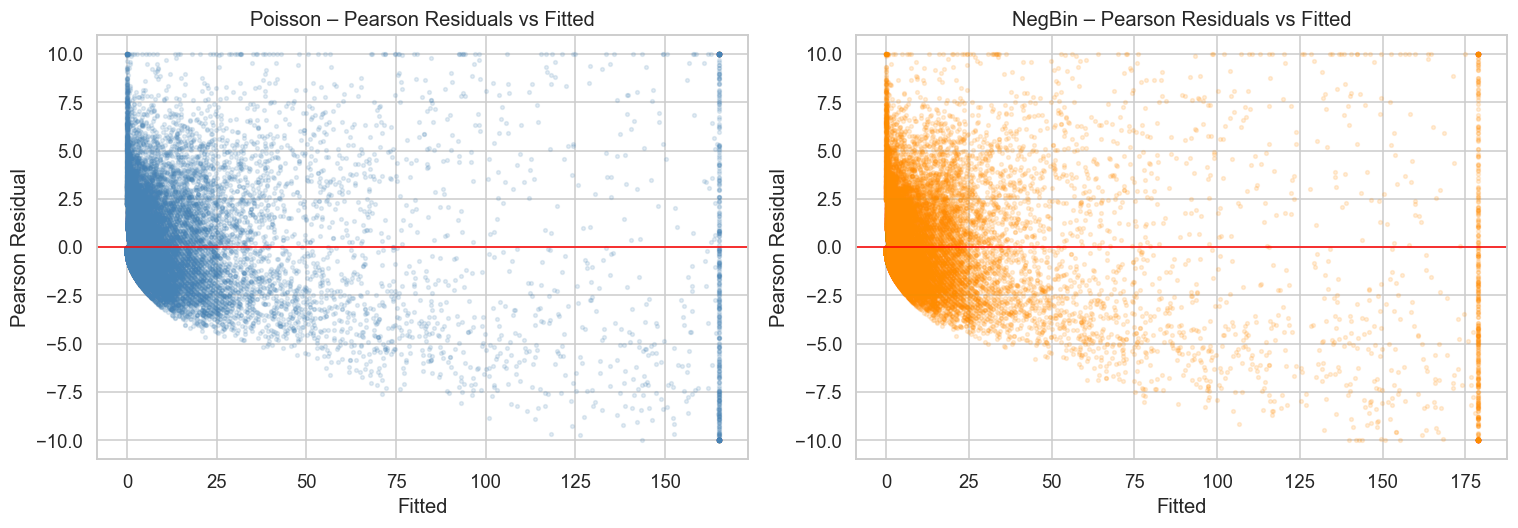

In [30]:
train = train.copy()
train['pred_pois'] = glm_pois.predict(train, offset=train['log_exposure'])
train['pred_nb']   = glm_nb.predict(  train, offset=train['log_exposure'])

# Pearson residuals
train['resid_pois'] = (train['y'] - train['pred_pois']) / np.sqrt(train['pred_pois'].clip(lower=1e-6))
train['resid_nb']   = (train['y'] - train['pred_nb'])   / np.sqrt(train['pred_nb'].clip(lower=1e-6))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, col, label, color in zip(
        axes,
        ['resid_pois', 'resid_nb'],
        ['Poisson', 'NegBin'],
        ['steelblue', 'darkorange']):
    ax.scatter(train['pred_' + col.split('_')[1]].clip(upper=train['pred_' + col.split('_')[1]].quantile(0.99)),
               train[col].clip(-10,10), alpha=0.15, s=6, color=color)
    ax.axhline(0, color='red', linewidth=1)
    ax.set_title(f'{label} – Pearson Residuals vs Fitted')
    ax.set_xlabel('Fitted'); ax.set_ylabel('Pearson Residual')
plt.tight_layout(); plt.show()

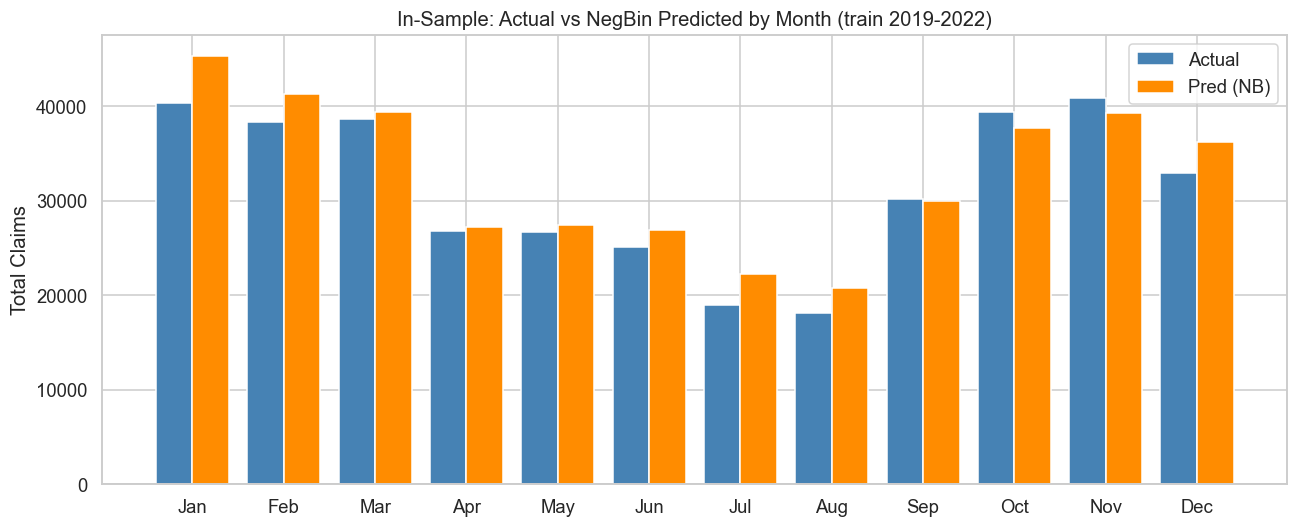

In [31]:
# Actual vs Predicted – in-sample by month
check = (
    train.groupby('treatment_month')
         .agg(actual=('y','sum'), pred_nb=('pred_nb','sum'))
         .reset_index()
)
x = np.arange(12)
fig, ax = plt.subplots(figsize=(12,5))
ax.bar(x-0.2, check['actual'], 0.4, label='Actual',    color='steelblue')
ax.bar(x+0.2, check['pred_nb'], 0.4, label='Pred (NB)', color='darkorange')
ax.set_xticks(x); ax.set_xticklabels(month_names)
ax.set_title('In-Sample: Actual vs NegBin Predicted by Month (train 2019-2022)')
ax.set_ylabel('Total Claims')
ax.legend(); plt.tight_layout(); plt.show()

> **In-sample fit by month**
> This chart checks whether the model captures the **seasonal amplitude** correctly.
> If the bars are roughly equal height the model has successfully learnt the month
> fixed-effects. Large discrepancies in specific months may indicate:
> - Interaction between month and another covariate not captured (e.g. flu season
>   hitting certain age groups harder).
> - Data quality issues in a particular month.

## Section 12 – IRR Interpretation

> ### Incidence Rate Ratios (IRR) — interpretation guide
>
> The exponentiated GLM coefficient is the **Incidence Rate Ratio**:
>
> | IRR | Meaning |
> |-----|---------|
> | 1.0 | No difference vs reference level |
> | 1.20 | 20 % higher consultation rate than reference |
> | 0.75 | 25 % lower consultation rate than reference |
>
> All IRRs are **ceteris paribus** — holding all other predictors constant.
> Only statistically significant IRRs (p < 0.05) should be used for pricing adjustments.
>
> The **forest plot** below shows the top and bottom significant effects —
> bars that do not cross the red dashed line (IRR = 1) are significant.

In [32]:
# Incidence Rate Ratios from NegBin model
irr = pd.DataFrame({
    'coef'   : glm_nb.params,
    'IRR'    : np.exp(glm_nb.params),
    'IRR_lo' : np.exp(glm_nb.conf_int()[0]),
    'IRR_hi' : np.exp(glm_nb.conf_int()[1]),
    'p_value': glm_nb.pvalues
}).reset_index().rename(columns={'index':'term'})

irr['significant'] = irr['p_value'] < 0.05
irr_sorted = irr.sort_values('IRR', ascending=False)

print('Top 20 IRR (NegBin model):')
display(irr_sorted[['term','IRR','IRR_lo','IRR_hi','p_value','significant']].head(20).reset_index(drop=True))

Top 20 IRR (NegBin model):


,term,IRR,IRR_lo,IRR_hi,p_value,significant
0,C(nationality_grp)[T.JORDANIAN],1.890,1.739,2.055,0.000,True
1,C(nationality_grp)[T.SYRIAN],1.798,1.648,1.961,0.000,True
2,C(nationality_grp)[T.EMIRATI],1.656,1.524,1.799,0.000,True
3,C(nationality_grp)[T.EGYPTIAN],1.536,1.412,1.670,0.000,True
4,C(nationality_grp)[T.PAKISTANI],1.385,1.273,1.507,0.000,True
5,C(nationality_grp)[T.OTHER],1.292,1.192,1.400,0.000,True
6,C(nationality_grp)[T.INDIAN],1.213,1.118,1.315,0.000,True
7,C(marital_status)[T.MARRIED],1.178,0.930,1.491,0.174,False
8,C(marital_status)[T.SINGLE],1.049,0.828,1.329,0.692,False
9,C(nationality_grp)[T.BRITISH],1.027,0.939,1.122,0.563,False


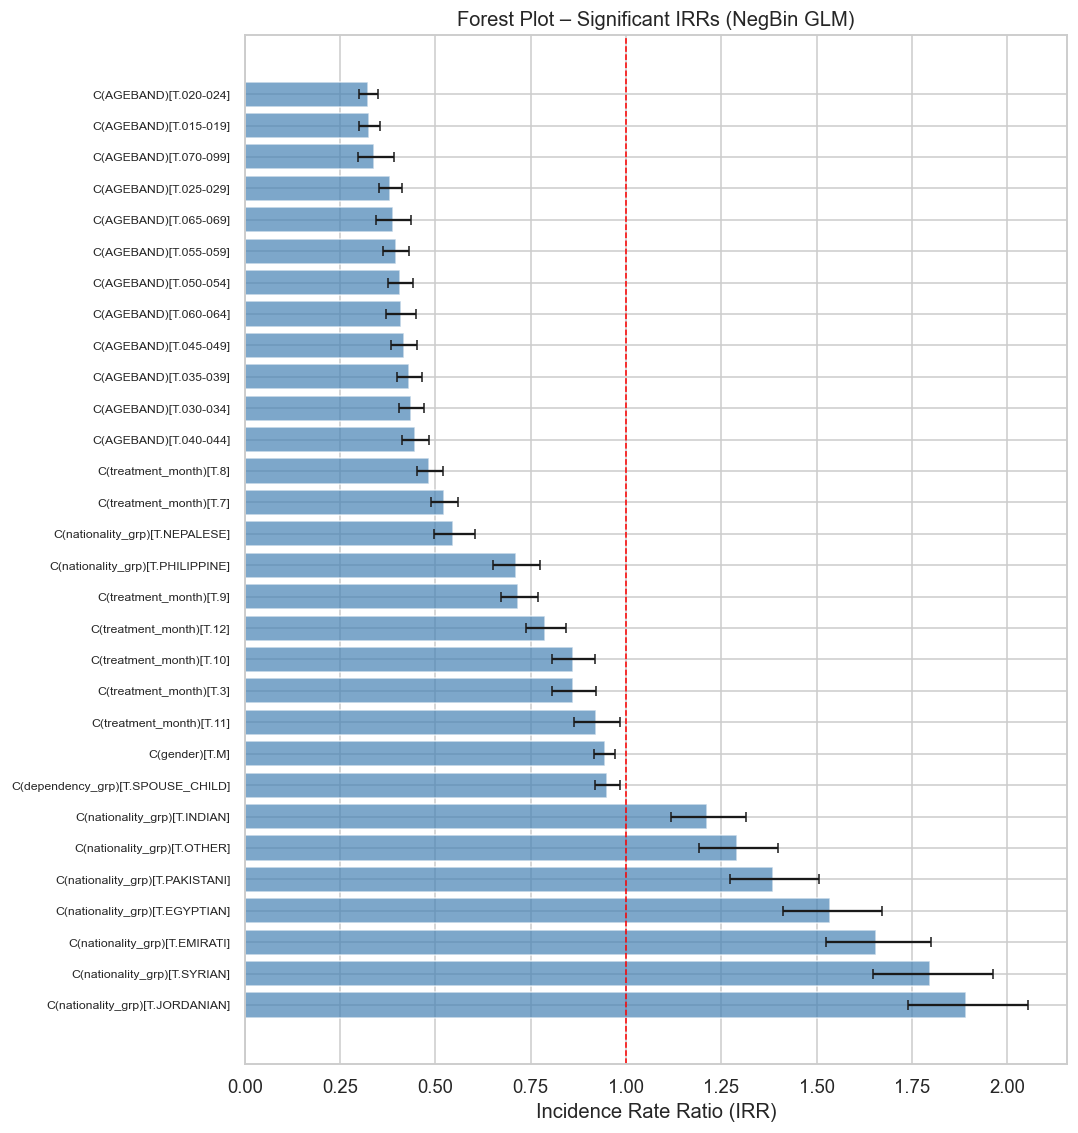

In [33]:
# Forest plot of significant IRRs (excluding intercept)
fp = irr_sorted[
        irr_sorted['significant'] &
        ~irr_sorted['term'].str.lower().str.contains('intercept')
     ].copy()

# Limit to top+bottom 15 for readability
fp_plot = pd.concat([fp.head(15), fp.tail(15)]).drop_duplicates()

fig, ax = plt.subplots(figsize=(10, max(6, len(fp_plot)*0.35)))
y_pos = np.arange(len(fp_plot))
ax.barh(y_pos, fp_plot['IRR'], xerr=[
            fp_plot['IRR'] - fp_plot['IRR_lo'],
            fp_plot['IRR_hi'] - fp_plot['IRR']
        ], color='steelblue', alpha=0.7, capsize=3)
ax.axvline(1, color='red', linestyle='--', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(fp_plot['term'].values, fontsize=8)
ax.set_xlabel('Incidence Rate Ratio (IRR)')
ax.set_title('Forest Plot – Significant IRRs (NegBin GLM)')
plt.tight_layout(); plt.show()

## Section 13 – Holdout Evaluation (2023)

> ### Holdout validation methodology
>
> The model is trained on **2019–2022** and evaluated on **2023** (unseen data).
> This simulates a real pricing exercise where the model trained on historical
> data is used to predict next year's claims.
>
> **Metrics used**:
> - **MAE** (Mean Absolute Error) — average absolute deviation per risk cell
> - **RMSE** — penalises large errors more than MAE; sensitive to outliers
> - **Portfolio bias** = (total predicted − total actual) / total actual × 100 %
>   - The most critical metric for actuarial pricing: a positive bias means
>     the model *over-predicts* claims; negative means it *under-predicts*.
>   - A well-calibrated model has |bias| < 5 %.

In [34]:
test = test.copy()

# Safety: remap any test levels not seen in train -> 'OTHER'
# (prevents NaN predictions from unseen categorical levels)
train_nat_levels = set(train['nationality_grp'].unique())
train_dep_levels  = set(train['dependency_grp'].unique())
train_ms_levels   = set(train['marital_status'].unique())
train_age_levels  = set(train['AGEBAND'].unique())

test['nationality_grp'] = test['nationality_grp'].where(
    test['nationality_grp'].isin(train_nat_levels), 'OTHER')
test['dependency_grp']  = test['dependency_grp'].where(
    test['dependency_grp'].isin(train_dep_levels),  'OTHER')
test['marital_status']  = test['marital_status'].where(
    test['marital_status'].isin(train_ms_levels),   test['marital_status'].mode()[0])
test['AGEBAND']         = test['AGEBAND'].where(
    test['AGEBAND'].isin(train_age_levels),          test['AGEBAND'].mode()[0])

test['pred_pois'] = glm_pois.predict(test, offset=test['log_exposure'])
test['pred_nb']   = glm_nb.predict(  test, offset=test['log_exposure'])

# Check for any remaining NaN in predictions
nan_pois = test['pred_pois'].isna().sum()
nan_nb   = test['pred_nb'].isna().sum()
if nan_pois > 0 or nan_nb > 0:
    print(f'WARNING: {nan_pois} NaN in Poisson pred, {nan_nb} NaN in NegBin pred')
    print('Dropping NaN rows for evaluation...')
    test = test.dropna(subset=['pred_pois','pred_nb']).copy()

def metrics(y_true, y_pred, label=''):
    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    total_true = y_true.sum()
    total_pred = y_pred.sum()
    bias = (total_pred - total_true) / total_true * 100
    print(f'{label}')
    print(f'  MAE            : {mae:,.3f}')
    print(f'  RMSE           : {rmse:,.3f}')
    print(f'  Total actual   : {total_true:,.0f}')
    print(f'  Total predicted: {total_pred:,.0f}')
    print(f'  Portfolio bias : {bias:+.2f}%')

metrics(test['y'].values, test['pred_pois'].values, label='Poisson GLM (2023 holdout)')
print()
metrics(test['y'].values, test['pred_nb'].values,   label='NegBin  GLM (2023 holdout)')


Dropping NaN rows for evaluation...
Poisson GLM (2023 holdout)
  MAE            : 3.857
  RMSE           : 17.188
  Total actual   : 109,950
  Total predicted: 102,322
  Portfolio bias : -6.94%

NegBin  GLM (2023 holdout)
  MAE            : 4.127
  RMSE           : 18.353
  Total actual   : 109,950
  Total predicted: 107,079
  Portfolio bias : -2.61%


> **Holdout result interpretation**
> Compare Poisson vs NegBin portfolio bias:
> - Both should predict similar *totals* (since NegBin retains the same mean structure).
> - NegBin typically gives smaller cell-level MAE/RMSE due to better handling of
>   high-count outlier cells.
> - A systematic positive bias (+X %) in 2023 may reflect post-COVID demand rebound
>   not fully captured in the 2019–2022 training trend.

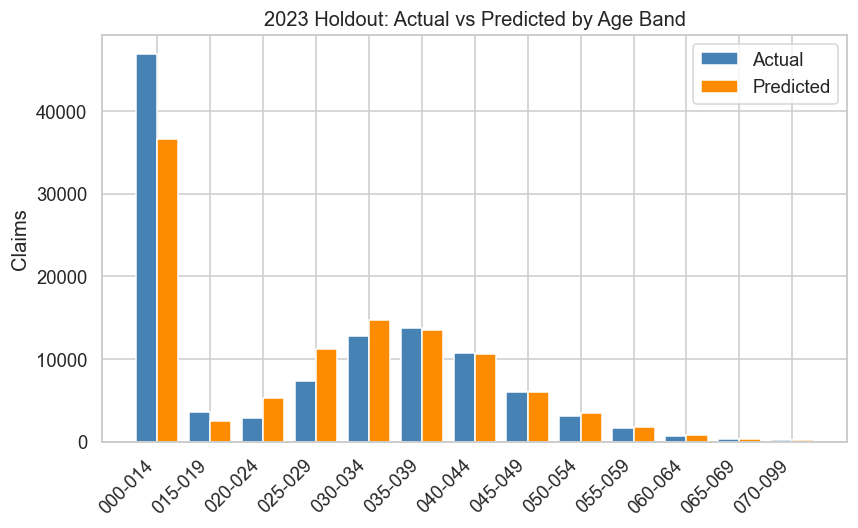

,AGEBAND,actual,predicted,ratio
0,000-014,46926,"36,621.393",0.780
1,015-019,3536,"2,483.691",0.702
2,020-024,2840,"5,318.007",1.873
3,025-029,7340,"11,275.530",1.536
4,030-034,12827,"14,763.285",1.151
5,035-039,13704,"13,529.342",0.987
6,040-044,10710,"10,593.747",0.989
7,045-049,6034,"5,995.008",0.994
8,050-054,3075,"3,460.718",1.125
9,055-059,1694,"1,774.635",1.048


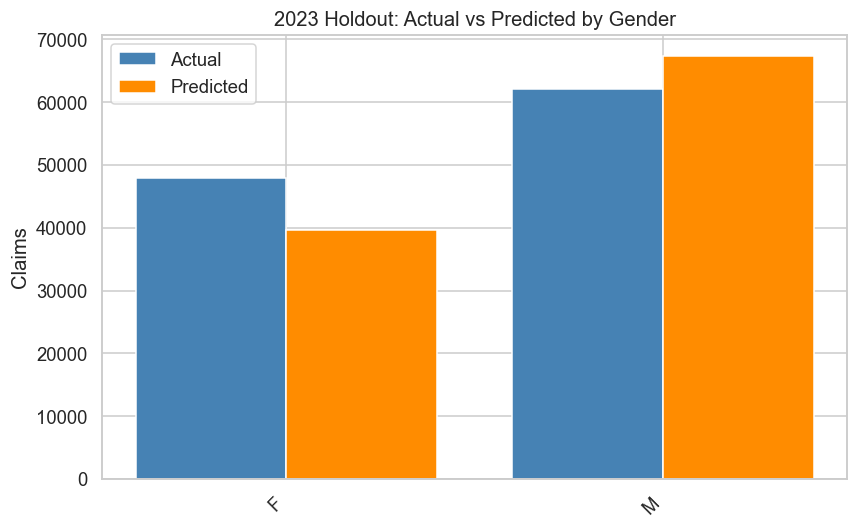

,gender,actual,predicted,ratio
0,F,47900,"39,697.032",0.829
1,M,62050,"67,381.617",1.086


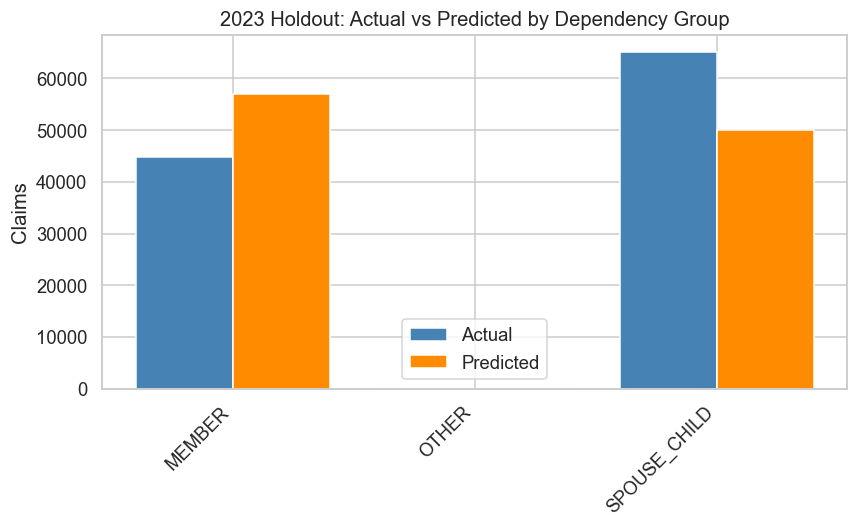

,dependency_grp,actual,predicted,ratio
0,MEMBER,44738,"57,052.421",1.275
1,OTHER,24,30.156,1.256
2,SPOUSE_CHILD,65188,"49,996.072",0.767


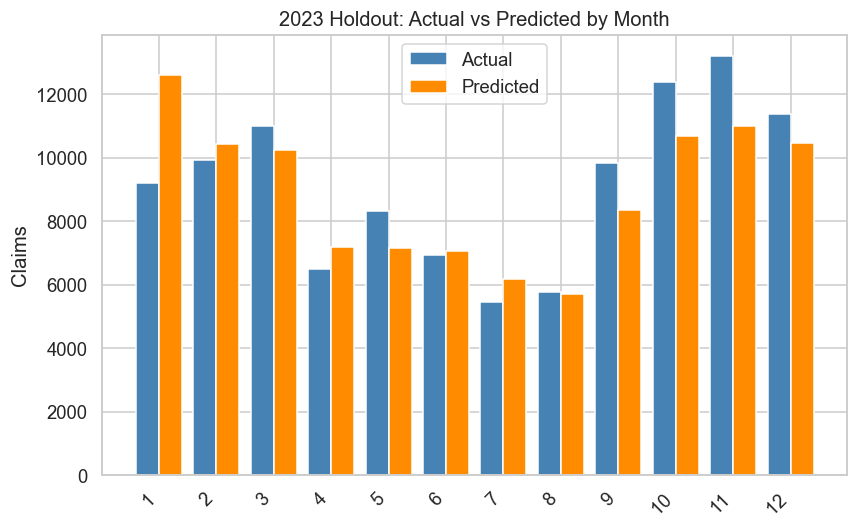

,treatment_month,actual,predicted,ratio
0,1,9201,"12,602.017",1.370
1,2,9932,"10,439.947",1.051
2,3,11010,"10,233.565",0.929
3,4,6508,"7,199.779",1.106
4,5,8329,"7,148.852",0.858
5,6,6937,"7,060.322",1.018
6,7,5441,"6,166.156",1.133
7,8,5776,"5,707.601",0.988
8,9,9839,"8,354.135",0.849
9,10,12377,"10,696.349",0.864


In [35]:
# By dimension: actual vs predicted (NegBin)
def avp_by(col, label):
    t = (
        test.groupby(col)
            .agg(actual=('y','sum'), predicted=('pred_nb','sum'))
            .reset_index()
    )
    t['ratio'] = t['predicted'] / t['actual'].clip(lower=1)
    t = t.sort_values(col)
    x = np.arange(len(t))
    fig, ax = plt.subplots(figsize=(max(8,len(t)*0.5+1), 5))
    ax.bar(x-0.2, t['actual'],    0.4, label='Actual',    color='steelblue')
    ax.bar(x+0.2, t['predicted'], 0.4, label='Predicted', color='darkorange')
    ax.set_xticks(x); ax.set_xticklabels(t[col].astype(str), rotation=45, ha='right')
    ax.set_title(f'2023 Holdout: Actual vs Predicted by {label}')
    ax.set_ylabel('Claims'); ax.legend()
    plt.tight_layout(); plt.show()
    display(t)

avp_by('AGEBAND',        'Age Band')
avp_by('gender',         'Gender')
avp_by('dependency_grp', 'Dependency Group')
avp_by('treatment_month','Month')

## Section 14 – 30-Day & 15-Day Projections (Seasonality-Adjusted)

> ### 30-day and 15-day projection methodology
>
> The GLM produces **monthly** expected counts (tied to the cell's earned-days exposure).
> To project over a *different* horizon we scale proportionally:
>
> $$\hat{Y}_{30d} = \hat{Y}_{monthly} 	imes 
rac{30}{ar{d}_{month}} 	imes S_m$$
>
> where:
> - $ar{d}_{month} = 365.25/12 = 30.44$ — average days in a calendar month
> - $S_m$ — seasonal index for month $m$ (from training data)
>
> When the target horizon = 30 days ≈ one calendar month, $\hat{Y}_{30d} pprox \hat{Y}_{monthly}$.
> The seasonal index adjusts for the fact that some months have inherently higher
> respiratory risk than an average month.
>
> **Practical use**: these projections estimate expected consultations over the
> next 30 or 15 days for planning workforce capacity, pre-authorization budgets,
> or short-term cash-flow reserving.

In [36]:
# ===========================================================================
# 30-day and 15-day projections from monthly NegBin predictions
# ===========================================================================
# Since the GLM is fitted on MONTHLY data, pred_nb is already a monthly
# expected count over the cell's earned-days exposure in that month.
#
# To project over a DIFFERENT horizon (30 or 15 days) we scale by:
#     (target_days / avg_days_per_month) * seasonal_index
#
# where avg_days_per_month = DAYS_YEAR / 12 = 30.44
#
# seasonal_index accounts for months being above/below the annual average.
# ---------------------------------------------------------------------------

AVG_MONTH_DAYS = DAYS_YEAR / 12   # 30.44

season_map = season_idx['seasonal_idx'].to_dict()
test['season_idx'] = test['treatment_month'].map(season_map).fillna(1.0)

# Scale from monthly pred -> target horizon
test['pred_30d'] = test['pred_nb'] * (30 / AVG_MONTH_DAYS) * test['season_idx']
test['pred_15d'] = test['pred_nb'] * (15 / AVG_MONTH_DAYS) * test['season_idx']

# Sanity check: pred_30d should be close to pred_nb (since 30 ~ avg month)
print(f'avg_month_days       = {AVG_MONTH_DAYS:.2f}')
print(f'Total pred_nb        = {test["pred_nb"].sum():,.0f}')
print(f'Total pred_30d       = {test["pred_30d"].sum():,.0f}  (expect ~ pred_nb)')
print(f'Total pred_15d       = {test["pred_15d"].sum():,.0f}  (expect ~ pred_nb / 2)')
print(f'Total actual_monthly = {test["y"].sum():,.0f}')

horizon_summary = (
    test.groupby('treatment_month')
        .agg(
            actual_monthly =('y',        'sum'),
            pred_nb_monthly=('pred_nb',  'sum'),
            pred_30d       =('pred_30d', 'sum'),
            pred_15d       =('pred_15d', 'sum'),
        )
        .reset_index()
)
horizon_summary['month_name'] = [month_names[m-1] for m in horizon_summary['treatment_month']]
display(horizon_summary.set_index('month_name').drop(columns='treatment_month').round(0))


avg_month_days       = 30.44
Total pred_nb        = 107,079
Total pred_30d       = 110,970  (expect ~ pred_nb)
Total pred_15d       = 55,485  (expect ~ pred_nb / 2)
Total actual_monthly = 109,950


,actual_monthly,pred_nb_monthly,pred_30d,pred_15d
month_name,,,,
Jan,9201,"12,602.000","15,343.000","7,672.000"
Feb,9932,"10,440.000","13,109.000","6,554.000"
Mar,11010,"10,234.000","11,719.000","5,859.000"
Apr,6508,"7,200.000","6,197.000","3,099.000"
May,8329,"7,149.000","6,037.000","3,018.000"
Jun,6937,"7,060.000","5,773.000","2,886.000"
Jul,5441,"6,166.000","3,738.000","1,869.000"
Aug,5776,"5,708.000","3,281.000","1,641.000"
Sep,9839,"8,354.000","8,194.000","4,097.000"


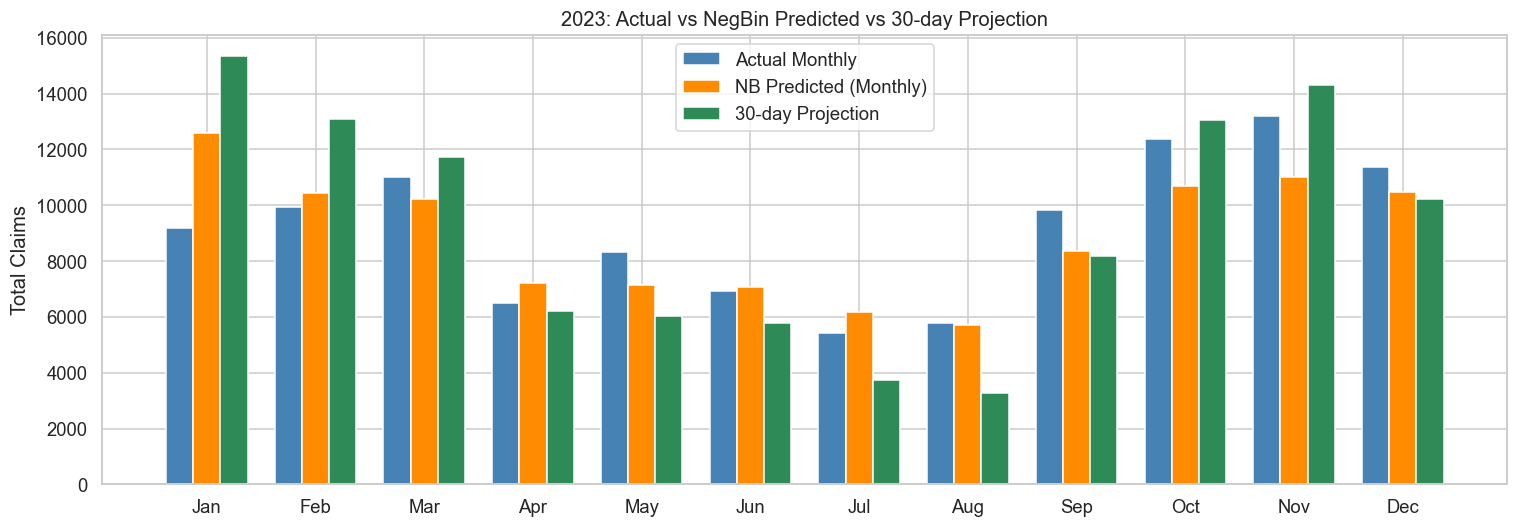

In [37]:
# Plot: 30d vs 15d projections alongside actual
x = np.arange(len(horizon_summary))
w = 0.25
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(x - w,   horizon_summary['actual_monthly'],  w, label='Actual Monthly',   color='steelblue')
ax.bar(x,       horizon_summary['pred_nb_monthly'],  w, label='NB Predicted (Monthly)', color='darkorange')
ax.bar(x + w,   horizon_summary['pred_30d'],         w, label='30-day Projection', color='seagreen')
ax.set_xticks(x)
ax.set_xticklabels(horizon_summary['month_name'])
ax.set_title('2023: Actual vs NegBin Predicted vs 30-day Projection')
ax.set_ylabel('Total Claims')
ax.legend(); plt.tight_layout(); plt.show()

## Section 15 – Top Risk Cells

> **Top risk cell interpretation**
> The table below ranks cells by **predicted rate per 1,000 earned days** —
> the exposure-adjusted measure of risk intensity.
> High-rate cells are the primary candidates for:
> - Targeted wellness interventions
> - More granular premium loadings
> - Case management flag-lists
>
> Note that a cell with very high rate but very low exposure (few members) has
> limited *absolute* impact on total claims — check both rate and absolute count columns.

In [38]:
# Highest predicted frequency (rate per 1,000 days)
test['pred_rate_1000'] = test['pred_nb'] / test['exposure'] * 1000

top_cells = (
    test.sort_values('pred_rate_1000', ascending=False)
        [['treatment_year','treatment_month','AGEBAND','gender',
          'nationality_grp','dependency_grp',
          'exposure','y','pred_nb','pred_rate_1000','pred_30d','pred_15d']]
        .head(20)
        .reset_index(drop=True)
)
print('Top 20 highest-risk cells (2023 holdout):')
display(top_cells)

Top 20 highest-risk cells (2023 holdout):


,treatment_year,treatment_month,AGEBAND,gender,nationality_grp,dependency_grp,exposure,y,pred_nb,pred_rate_1000,pred_30d,pred_15d
0,2023,1,000-014,F,JORDANIAN,SPOUSE_CHILD,0.331,1,0.443,"1,336.869",0.539,0.270
1,2023,2,000-014,F,JORDANIAN,SPOUSE_CHILD,0.153,0,0.205,"1,334.011",0.257,0.128
2,2023,11,000-014,F,JORDANIAN,SPOUSE_CHILD,0.656,0,0.809,"1,232.535",1.051,0.526
3,2023,1,000-014,M,SYRIAN,SPOUSE_CHILD,0.170,1,0.204,"1,200.102",0.248,0.124
4,2023,2,000-014,M,SYRIAN,SPOUSE_CHILD,0.153,1,0.184,"1,197.536",0.231,0.115
5,2023,1,000-014,F,JORDANIAN,SPOUSE_CHILD,196.298,108,233.696,"1,190.515",284.528,142.264
6,2023,2,000-014,F,JORDANIAN,SPOUSE_CHILD,167.477,120,198.958,"1,187.970",249.817,124.909
7,2023,11,000-014,F,SYRIAN,SPOUSE_CHILD,0.170,0,0.200,"1,172.262",0.260,0.130
8,2023,1,000-014,F,EMIRATI,SPOUSE_CHILD,0.255,1,0.298,"1,170.871",0.363,0.182
9,2023,2,000-014,F,EMIRATI,SPOUSE_CHILD,0.230,3,0.269,"1,168.367",0.338,0.169


In [39]:
print('\n=== Analysis Complete ===')
print('Models fitted   : Poisson GLM, Negative Binomial GLM')
print('Holdout year    : 2023')
print('Projections     : 30-day & 15-day (seasonality-adjusted)')
print('Next steps      : tune NB alpha, add interaction terms, or try GLM with regularisation')


=== Analysis Complete ===
Models fitted   : Poisson GLM, Negative Binomial GLM
Holdout year    : 2023
Projections     : 30-day & 15-day (seasonality-adjusted)
Next steps      : tune NB alpha, add interaction terms, or try GLM with regularisation


---
## Section 16 – Pre-COVID vs Post-COVID Frequency Analysis

**Era definition**
| Era | Years | Rationale |
|-----|-------|-----------|
| Pre-COVID | 2019 | Baseline respiratory season before pandemic |
| COVID | 2020 | Lockdowns, mask mandates, suppressed in-person care-seeking |
| Post-COVID | 2021, 2022, 2023 | Rebound / endemic phase |

In [40]:
# ── Assign era labels ─────────────────────────────────────────────────────
era_map = {2019: 'Pre-COVID', 2020: 'COVID', 2021: 'Post-COVID',
           2022: 'Post-COVID', 2023: 'Post-COVID'}
df['era'] = df['treatment_year'].map(era_map)

ERA_ORDER  = ['Pre-COVID', 'COVID', 'Post-COVID']
ERA_COLORS = {'Pre-COVID': 'steelblue', 'COVID': 'firebrick', 'Post-COVID': 'seagreen'}

# ── Era-level summary ─────────────────────────────────────────────────────
era_agg = (
    df.groupby('era')
      .agg(
          total_claims  =(TARGET,   'sum'),
          total_exp_days=(EXPOSURE, 'sum'),
          n_rows        =(TARGET,   'count'),
          n_members     =('distinct_member_count', 'sum')
      )
      .assign(freq_per_1000=lambda x: x['total_claims']/x['total_exp_days']*1000)
      .loc[ERA_ORDER]
)
display(era_agg.round(3))

,total_claims,total_exp_days,n_rows,n_members,freq_per_1000
era,,,,,
Pre-COVID,156854,"297,987.662",180219,3436074,526.377
COVID,74476,"277,266.446",148780,3072437,268.608
Post-COVID,255247,"943,378.857",527042,10444926,270.567


> **COVID-era analysis methodology**
>
> We partition the data into three epidemiological regimes:
> - **Pre-COVID (2019)**: baseline respiratory season, full care-seeking behaviour.
> - **COVID (2020)**: pandemic year — lockdowns, clinic closures, and *fear-avoidance*
>   all suppressed elective and semi-urgent respiratory consultations.
> - **Post-COVID (2021–2023)**: return to normalcy with potential *rebound demand*
>   as deferred care was sought and long-COVID respiratory sequelae emerged.
>
> **Statistical tests used**:
> - **Kruskal-Wallis H-test**: non-parametric one-way ANOVA; tests whether at least
>   one era has a different frequency distribution.
> - **Mann-Whitney U (pairwise)**: identifies *which* pairs differ significantly.
>
> The **GLM era IRR** (reference = Pre-COVID) is the most policy-relevant output:
> it quantifies the COVID suppression and post-COVID rebound as multiplicative
> rate factors, controlling for age, gender, nationality, and month.

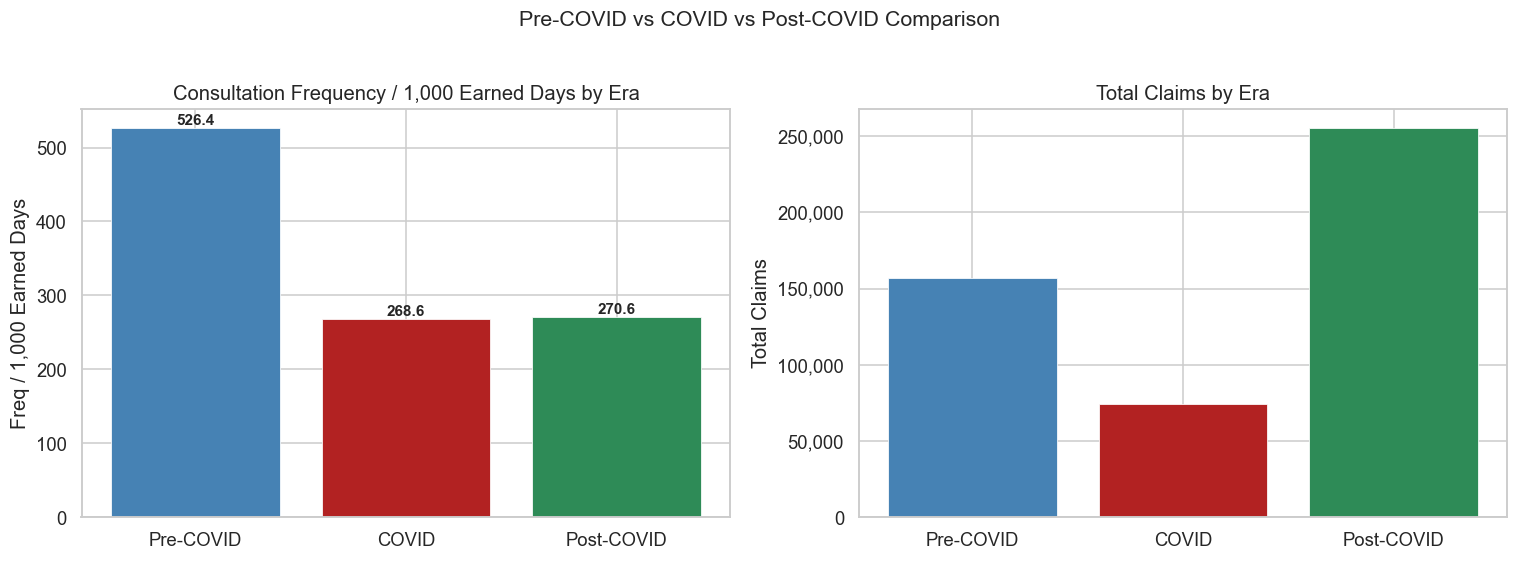

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar: frequency per 1,000 earned days
colors = [ERA_COLORS[e] for e in ERA_ORDER]
axes[0].bar(ERA_ORDER, era_agg['freq_per_1000'], color=colors, edgecolor='white', linewidth=0.5)
axes[0].set_title('Consultation Frequency / 1,000 Earned Days by Era')
axes[0].set_ylabel('Freq / 1,000 Earned Days')
for i, (era, val) in enumerate(zip(ERA_ORDER, era_agg['freq_per_1000'])):
    axes[0].text(i, val + 0.5, f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Bar: total claims
axes[1].bar(ERA_ORDER, era_agg['total_claims'], color=colors, edgecolor='white', linewidth=0.5)
axes[1].set_title('Total Claims by Era')
axes[1].set_ylabel('Total Claims')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x,_: f'{x:,.0f}'))

plt.suptitle('Pre-COVID vs COVID vs Post-COVID Comparison', fontsize=14, y=1.02)
plt.tight_layout(); plt.show()

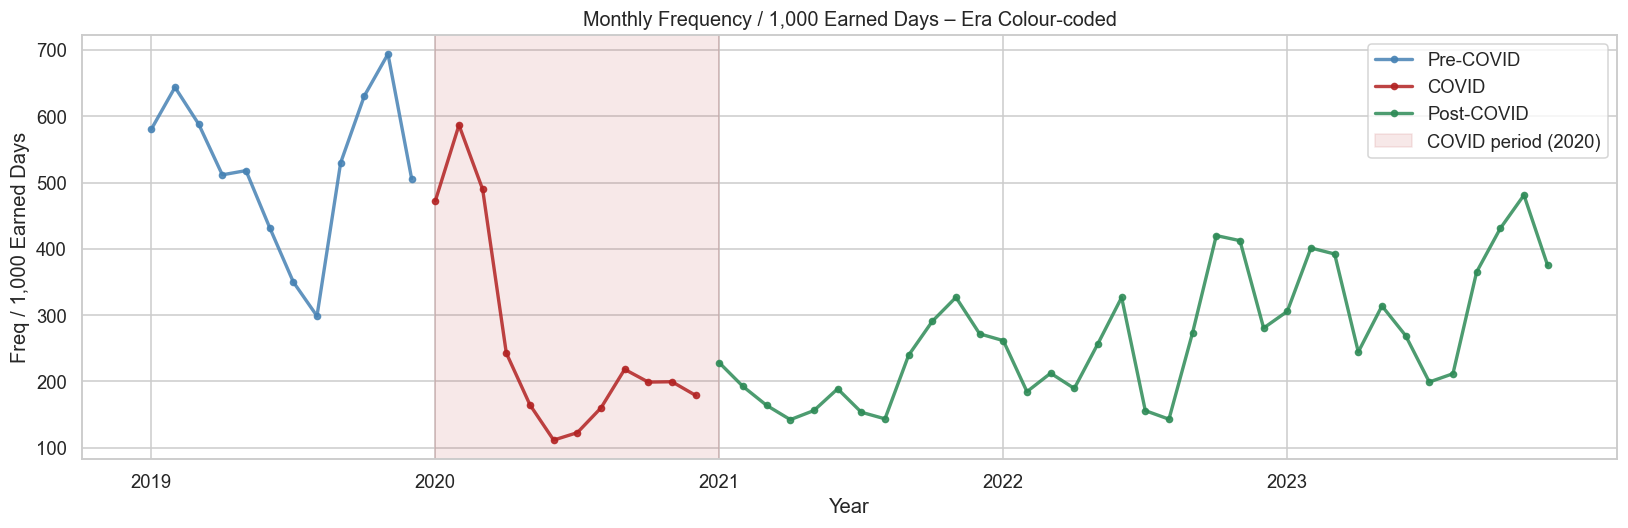

In [42]:
# Monthly time-series coloured by era
ts = (
    df.groupby(['treatment_year','treatment_month','era'])
      .agg(claims=(TARGET,'sum'), exp=(EXPOSURE,'sum'))
      .assign(freq=lambda x: x['claims']/x['exp']*1000)
      .reset_index()
)
ts['date_val'] = ts['treatment_year'] + (ts['treatment_month'] - 1)/12

fig, ax = plt.subplots(figsize=(15, 5))
for era in ERA_ORDER:
    sub = ts[ts['era'] == era].sort_values('date_val')
    ax.plot(sub['date_val'], sub['freq'], color=ERA_COLORS[era],
            linewidth=2.2, label=era, marker='o', markersize=4, alpha=0.85)

# Shade COVID year
ax.axvspan(2020, 2021, alpha=0.10, color='firebrick', label='COVID period (2020)')
ax.set_title('Monthly Frequency / 1,000 Earned Days – Era Colour-coded', fontsize=13)
ax.set_xlabel('Year'); ax.set_ylabel('Freq / 1,000 Earned Days')
ax.set_xticks([2019, 2020, 2021, 2022, 2023])
ax.legend(); plt.tight_layout(); plt.show()

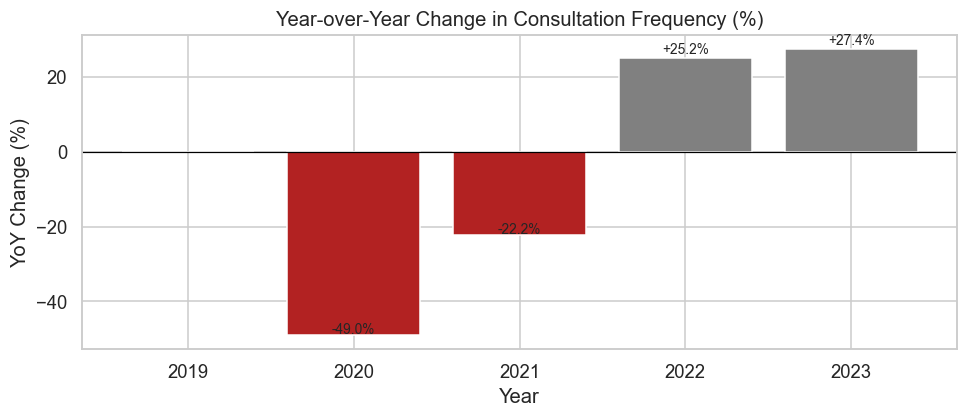

In [43]:
# Year-over-year change in frequency
yr_freq = (
    df.groupby('treatment_year')
      .agg(claims=(TARGET,'sum'), exp=(EXPOSURE,'sum'))
      .assign(freq=lambda x: x['claims']/x['exp']*1000)
      .reset_index()
)
yr_freq['yoy_pct'] = yr_freq['freq'].pct_change() * 100

fig, ax = plt.subplots(figsize=(9, 4))
bar_colors = ['grey' if v >= 0 else 'firebrick' for v in yr_freq['yoy_pct'].fillna(0)]
ax.bar(yr_freq['treatment_year'], yr_freq['yoy_pct'].fillna(0),
       color=bar_colors, edgecolor='white')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Year-over-Year Change in Consultation Frequency (%)')
ax.set_ylabel('YoY Change (%)')
ax.set_xlabel('Year')
for i, row in yr_freq.iterrows():
    if not pd.isna(row['yoy_pct']):
        ax.text(row['treatment_year'], row['yoy_pct'] + 0.3*(-1 if row['yoy_pct'] < 0 else 1),
                f"{row['yoy_pct']:+.1f}%", ha='center', va='bottom', fontsize=9)
plt.tight_layout(); plt.show()

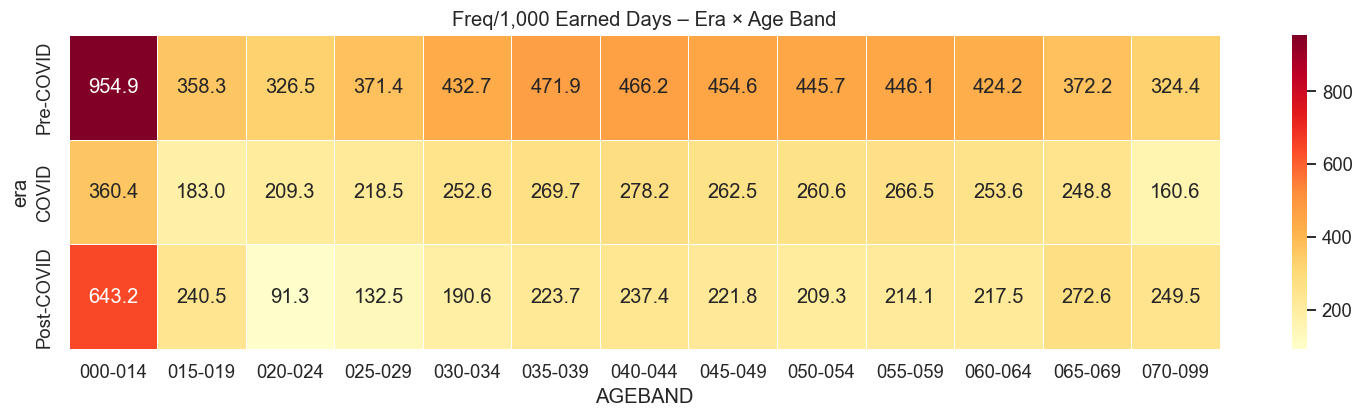

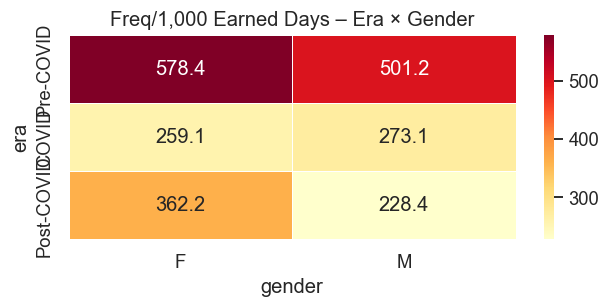

In [44]:
# Era × Age Band frequency heatmap
era_age = (
    df.groupby(['era','AGEBAND'])
      .agg(claims=(TARGET,'sum'), exp=(EXPOSURE,'sum'))
      .assign(freq=lambda x: x['claims']/x['exp']*1000)
      ['freq'].unstack('AGEBAND')
      .loc[ERA_ORDER]
)
# Sort age bands
era_age = era_age[sorted(era_age.columns)]

fig, ax = plt.subplots(figsize=(14, 4))
sns.heatmap(era_age, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=0.5, ax=ax)
ax.set_title('Freq/1,000 Earned Days – Era × Age Band')
plt.tight_layout(); plt.show()

# Era × Gender
era_gender = (
    df.groupby(['era','gender'])
      .agg(claims=(TARGET,'sum'), exp=(EXPOSURE,'sum'))
      .assign(freq=lambda x: x['claims']/x['exp']*1000)
      ['freq'].unstack('gender')
      .loc[ERA_ORDER]
)
fig, ax = plt.subplots(figsize=(6, 3))
sns.heatmap(era_gender, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=0.5, ax=ax)
ax.set_title('Freq/1,000 Earned Days – Era × Gender')
plt.tight_layout(); plt.show()

In [45]:
from scipy.stats import kruskal, mannwhitneyu

# Use row-level monthly freq per 1,000 for the test
pre  = df[df['era']=='Pre-COVID']['freq_per_1000'].dropna()
cov  = df[df['era']=='COVID']['freq_per_1000'].dropna()
post = df[df['era']=='Post-COVID']['freq_per_1000'].dropna()

stat_kw, p_kw = kruskal(pre, cov, post)
_, p_pre_covid = mannwhitneyu(pre, cov, alternative='two-sided')
_, p_pre_post  = mannwhitneyu(pre, post, alternative='two-sided')
_, p_cov_post  = mannwhitneyu(cov, post, alternative='two-sided')

print('=== Kruskal-Wallis test across all 3 eras ===')
print(f'H-statistic = {stat_kw:.2f},  p-value = {p_kw:.4e}')
print()
print('=== Pairwise Mann-Whitney U (two-sided) ===')
print(f'Pre-COVID  vs COVID       : p = {p_pre_covid:.4e}')
print(f'Pre-COVID  vs Post-COVID  : p = {p_pre_post:.4e}')
print(f'COVID      vs Post-COVID  : p = {p_cov_post:.4e}')

=== Kruskal-Wallis test across all 3 eras ===
H-statistic = 8615.97,  p-value = 0.0000e+00

=== Pairwise Mann-Whitney U (two-sided) ===
Pre-COVID  vs COVID       : p = 0.0000e+00
Pre-COVID  vs Post-COVID  : p = 0.0000e+00
COVID      vs Post-COVID  : p = 8.5995e-38


In [46]:
# GLM with era as a predictor – IRR shows COVID suppression effect
# Add era to cells table
cells['era'] = cells['treatment_year'].map(era_map)

train_era = cells[cells['treatment_year'].isin(TRAIN_YEARS)].copy()

formula_era = (
    'y ~ C(AGEBAND) + C(gender) + C(nationality_grp) + '
    'C(dependency_grp) + C(marital_status) + C(treatment_month) + '
    'C(era, Treatment(reference="Pre-COVID"))'
)

glm_era = smf.glm(
    formula_era,
    data   = train_era,
    family = sm.families.NegativeBinomial(alpha=1.0),
    offset = train_era['log_exposure']
).fit(maxiter=200)

# Extract era IRRs
era_irr = (
    pd.DataFrame({
        'IRR'    : np.exp(glm_era.params),
        'IRR_lo' : np.exp(glm_era.conf_int()[0]),
        'IRR_hi' : np.exp(glm_era.conf_int()[1]),
        'p_value': glm_era.pvalues
    })
    .reset_index()
    .rename(columns={'index':'term'})
    .query('term.str.contains("era")', engine='python')
)
print('Era Incidence Rate Ratios (reference = Pre-COVID):')
display(era_irr.round(4))
print()
print('Interpretation:')
print('  IRR < 1  →  fewer consultations relative to Pre-COVID baseline (COVID suppression)')
print('  IRR > 1  →  higher consultations relative to Pre-COVID baseline (rebound)')

Era Incidence Rate Ratios (reference = Pre-COVID):


,term,IRR,IRR_lo,IRR_hi,p_value
39,"C(era, Treatment(reference=""Pre-COVID""))[T.COVID]",0.545,0.524,0.567,0.000
40,"C(era, Treatment(reference=""Pre-COVID""))[T.Pos...",0.468,0.452,0.484,0.000



Interpretation:
  IRR < 1  →  fewer consultations relative to Pre-COVID baseline (COVID suppression)
  IRR > 1  →  higher consultations relative to Pre-COVID baseline (rebound)


> **Interpreting the era IRRs**
> - **COVID IRR < 1** confirms statistically significant suppression of consultations
>   during 2020 relative to the pre-pandemic baseline.
> - **Post-COVID IRR > 1**: values significantly above 1 indicate demand rebound —
>   important for prospective pricing as the portfolio may sustain elevated frequency
>   beyond 2023.
> - If Post-COVID IRR ≈ 1 (not significant), risk has reverted to pre-pandemic levels.

---
## Section 17 – Seasonality Impact on Predictability

We compare two model specifications on the 2023 holdout:
- **Model A (No Season)**: NegBin GLM *without* month fixed effects
- **Model B (With Season)**: NegBin GLM *with* `C(treatment_month)` ← already fitted as `glm_nb`

This isolates the contribution of seasonality to prediction accuracy.

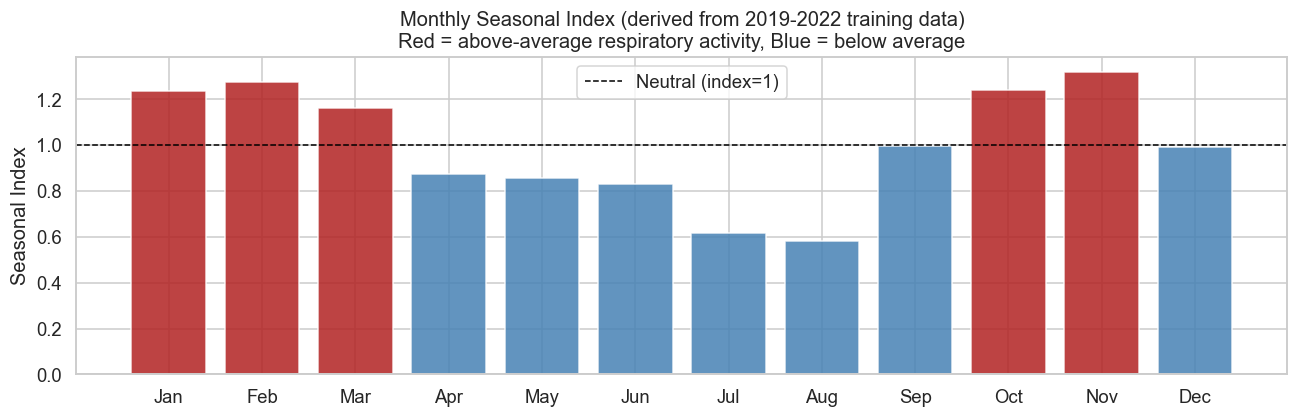

Peak months:


treatment_month
11   1.319
2    1.274
10   1.239
1    1.235
Name: seasonal_idx, dtype: float64


Trough months:


treatment_month
8   0.583
7   0.615
6   0.830
5   0.857
Name: seasonal_idx, dtype: float64

In [47]:
# Plot seasonal indices calculated in Section 8
fig, ax = plt.subplots(figsize=(12, 4))
si = season_idx['seasonal_idx'].reset_index()
bar_colors = ['firebrick' if v > 1 else 'steelblue' for v in si['seasonal_idx']]
ax.bar(si['treatment_month'], si['seasonal_idx'], color=bar_colors, alpha=0.85)
ax.axhline(1.0, color='black', linestyle='--', linewidth=1, label='Neutral (index=1)')
ax.set_xticks(range(1,13)); ax.set_xticklabels(month_names)
ax.set_title('Monthly Seasonal Index (derived from 2019-2022 training data)\n'
             'Red = above-average respiratory activity, Blue = below average')
ax.set_ylabel('Seasonal Index')
ax.legend(); plt.tight_layout(); plt.show()

print('Peak months:')
display(si.set_index('treatment_month')['seasonal_idx'].sort_values(ascending=False).head(4).round(3))
print('\nTrough months:')
display(si.set_index('treatment_month')['seasonal_idx'].sort_values().head(4).round(3))

In [48]:
# Model A – No month effect
formula_no_season = (
    'y ~ C(AGEBAND) + C(gender) + C(nationality_grp) + '
    'C(dependency_grp) + C(marital_status)'
)

glm_no_season = smf.glm(
    formula_no_season,
    data   = train,
    family = sm.families.NegativeBinomial(alpha=1.0),
    offset = train['log_exposure']
).fit(maxiter=200)

# Model B is already glm_nb (with month)
print(f'Model A (No Season)  – AIC: {glm_no_season.aic:,.1f}')
print(f'Model B (With Season)– AIC: {glm_nb.aic:,.1f}')
print(f'Delta AIC (A-B): {glm_no_season.aic - glm_nb.aic:,.1f}  '
      f'(positive = seasonality improves fit)')

Model A (No Season)  – AIC: 141,464.1
Model B (With Season)– AIC: 140,498.2
Delta AIC (A-B): 965.9  (positive = seasonality improves fit)


> **Seasonality model comparison — what to look for**
>
> | Metric | Model A (No Season) | Model B (With Season) |
> |--------|--------------------|-----------------------|
> | AIC | Higher (worse) | Lower (better) |
> | Portfolio bias | Varies by month | More uniform |
> | MAPE (winter) | High (misses peak) | Lower |
> | MAPE (summer) | Low (flat prediction ok) | Similar |
>
> The **ΔAIC** quantifies how much information is gained by modelling seasonality.
> A reduction of >10 AIC points is considered substantial.
>
> The **monthly MAPE chart** shows *where* seasonality matters most —
> typically Jan–Mar (winter peak) where the no-season model systematically
> under-predicts, and Jun–Aug where it may over-predict.

In [49]:
test_s = test.copy()
test_s['pred_no_season'] = glm_no_season.predict(test_s, offset=test_s['log_exposure'])
test_s['pred_season']    = glm_nb.predict(        test_s, offset=test_s['log_exposure'])

def mae_rmse(y, yhat, label):
    mae  = np.mean(np.abs(y - yhat))
    rmse = np.sqrt(np.mean((y - yhat)**2))
    bias = (yhat.sum() - y.sum()) / y.sum() * 100
    return {'Model': label, 'MAE': mae, 'RMSE': rmse, 'Portfolio Bias%': bias,
            'Total Actual': y.sum(), 'Total Pred': yhat.sum()}

cmp = pd.DataFrame([
    mae_rmse(test_s['y'].values, test_s['pred_no_season'].values, 'A – No Seasonality'),
    mae_rmse(test_s['y'].values, test_s['pred_season'].values,    'B – With Seasonality'),
]).set_index('Model')

print('=== 2023 Holdout Comparison ===')
display(cmp.round(3))

=== 2023 Holdout Comparison ===


,MAE,RMSE,Portfolio Bias%,Total Actual,Total Pred
Model,,,,,
A – No Seasonality,4.556,20.197,-2.512,109950,"107,187.579"
B – With Seasonality,4.127,18.353,-2.612,109950,"107,078.649"


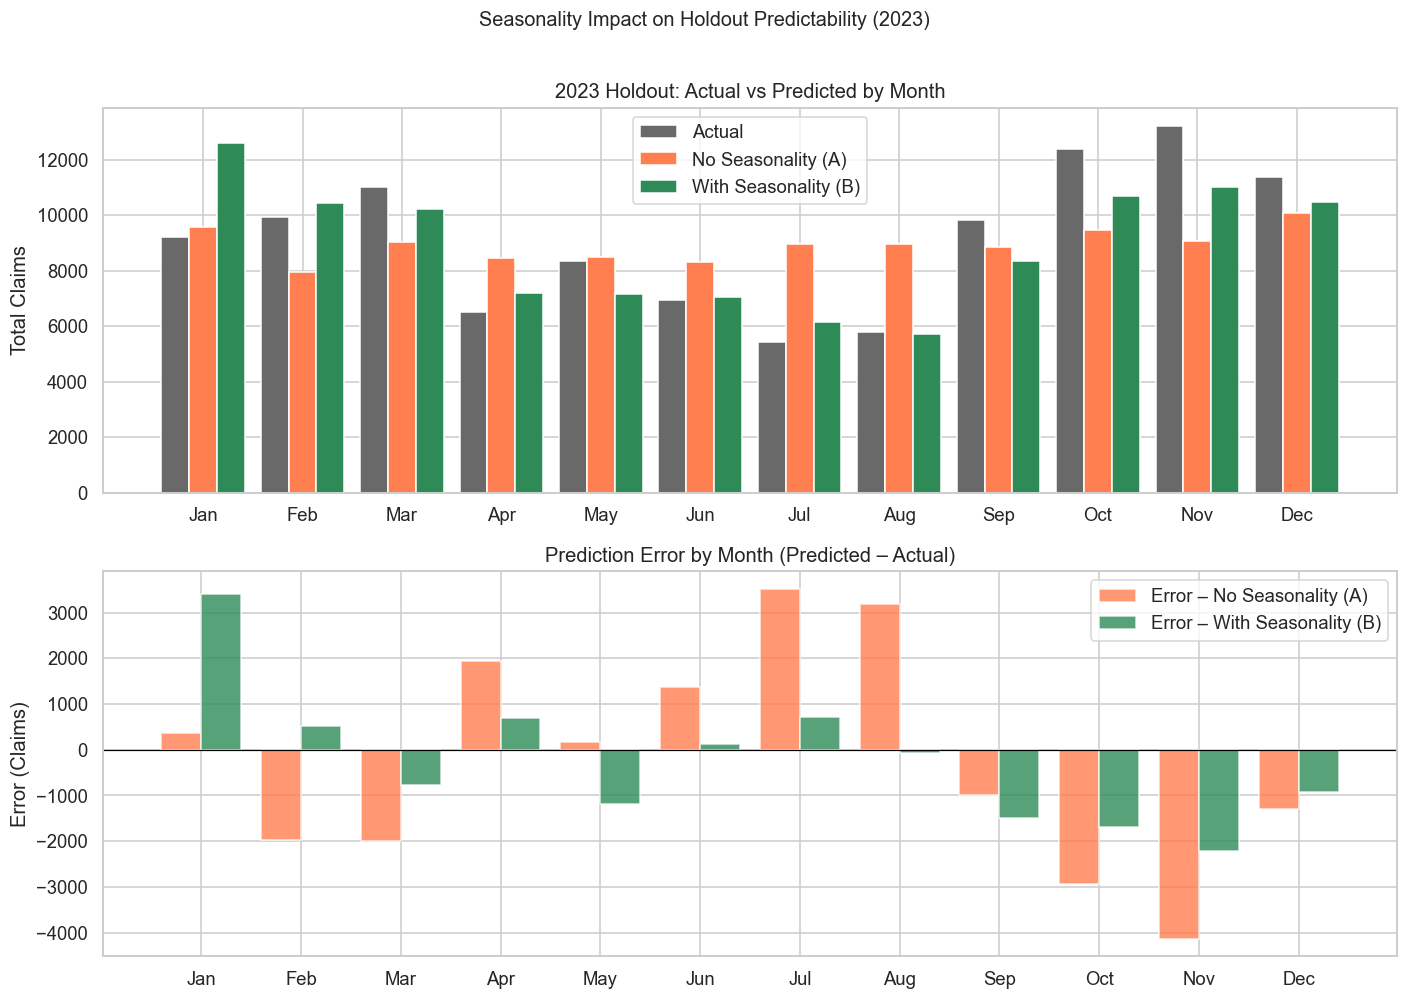

In [50]:
# Monthly actual vs predicted – side by side comparison
monthly_cmp = (
    test_s.groupby('treatment_month')
          .agg(
              actual       =('y',              'sum'),
              pred_no_seas =('pred_no_season', 'sum'),
              pred_seas    =('pred_season',    'sum')
          )
          .reset_index()
)
monthly_cmp['err_no_seas'] = monthly_cmp['pred_no_seas'] - monthly_cmp['actual']
monthly_cmp['err_seas']    = monthly_cmp['pred_seas']    - monthly_cmp['actual']

fig, axes = plt.subplots(2, 1, figsize=(13, 9))

# Panel 1: Predicted vs Actual by month
x = np.arange(12); w = 0.28
axes[0].bar(x - w,   monthly_cmp['actual'],      w, label='Actual',             color='dimgrey')
axes[0].bar(x,       monthly_cmp['pred_no_seas'], w, label='No Seasonality (A)', color='coral')
axes[0].bar(x + w,   monthly_cmp['pred_seas'],    w, label='With Seasonality (B)', color='seagreen')
axes[0].set_xticks(x); axes[0].set_xticklabels(month_names)
axes[0].set_title('2023 Holdout: Actual vs Predicted by Month')
axes[0].set_ylabel('Total Claims'); axes[0].legend()

# Panel 2: Prediction error (pred - actual)
axes[1].bar(x - 0.2, monthly_cmp['err_no_seas'], 0.4,
            label='Error – No Seasonality (A)', color='coral', alpha=0.8)
axes[1].bar(x + 0.2, monthly_cmp['err_seas'],    0.4,
            label='Error – With Seasonality (B)', color='seagreen', alpha=0.8)
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].set_xticks(x); axes[1].set_xticklabels(month_names)
axes[1].set_title('Prediction Error by Month (Predicted – Actual)')
axes[1].set_ylabel('Error (Claims)'); axes[1].legend()

plt.suptitle('Seasonality Impact on Holdout Predictability (2023)', fontsize=13, y=1.01)
plt.tight_layout(); plt.show()

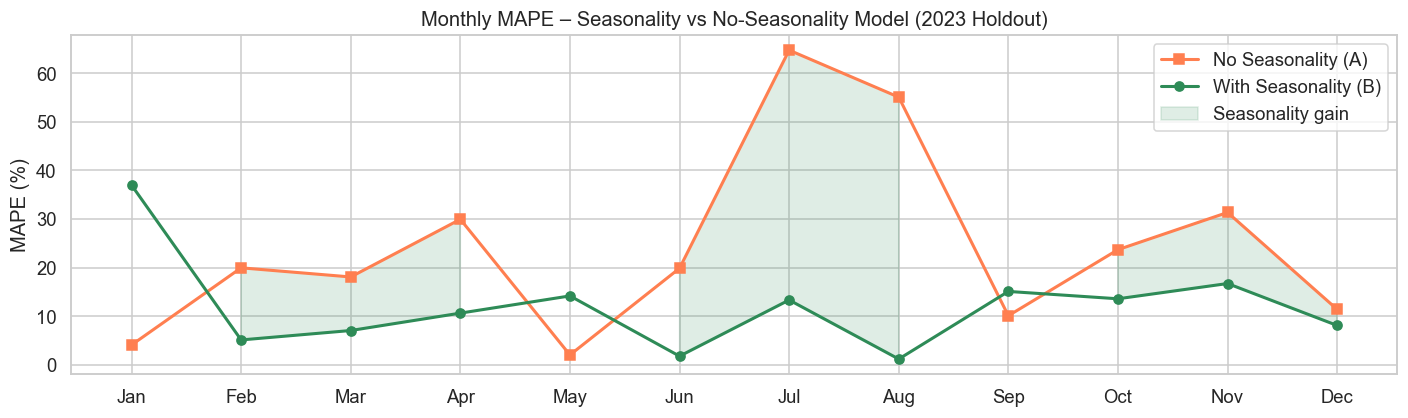


Overall MAPE – No Seasonality : 24.18%
Overall MAPE – With Seasonality: 11.97%
Average MAPE reduction from seasonality: 12.21 pp


In [51]:
# MAPE by month
monthly_cmp['mape_no_seas'] = (np.abs(monthly_cmp['err_no_seas']) /
                                monthly_cmp['actual'].clip(lower=1)) * 100
monthly_cmp['mape_seas']    = (np.abs(monthly_cmp['err_seas'])    /
                                monthly_cmp['actual'].clip(lower=1)) * 100
monthly_cmp['month_name']   = [month_names[m-1] for m in monthly_cmp['treatment_month']]

fig, ax = plt.subplots(figsize=(13, 4))
x = np.arange(12)
ax.plot(x, monthly_cmp['mape_no_seas'], marker='s', linewidth=2,
        color='coral',    label='No Seasonality (A)')
ax.plot(x, monthly_cmp['mape_seas'],    marker='o', linewidth=2,
        color='seagreen', label='With Seasonality (B)')
ax.fill_between(x,
                monthly_cmp['mape_no_seas'],
                monthly_cmp['mape_seas'],
                where=monthly_cmp['mape_no_seas'] >= monthly_cmp['mape_seas'],
                alpha=0.15, color='seagreen', label='Seasonality gain')
ax.set_xticks(x); ax.set_xticklabels(month_names)
ax.set_title('Monthly MAPE – Seasonality vs No-Seasonality Model (2023 Holdout)')
ax.set_ylabel('MAPE (%)')
ax.legend(); plt.tight_layout(); plt.show()

print(f"\nOverall MAPE – No Seasonality : {monthly_cmp['mape_no_seas'].mean():.2f}%")
print(f"Overall MAPE – With Seasonality: {monthly_cmp['mape_seas'].mean():.2f}%")
print(f"Average MAPE reduction from seasonality: "
      f"{monthly_cmp['mape_no_seas'].mean() - monthly_cmp['mape_seas'].mean():.2f} pp")

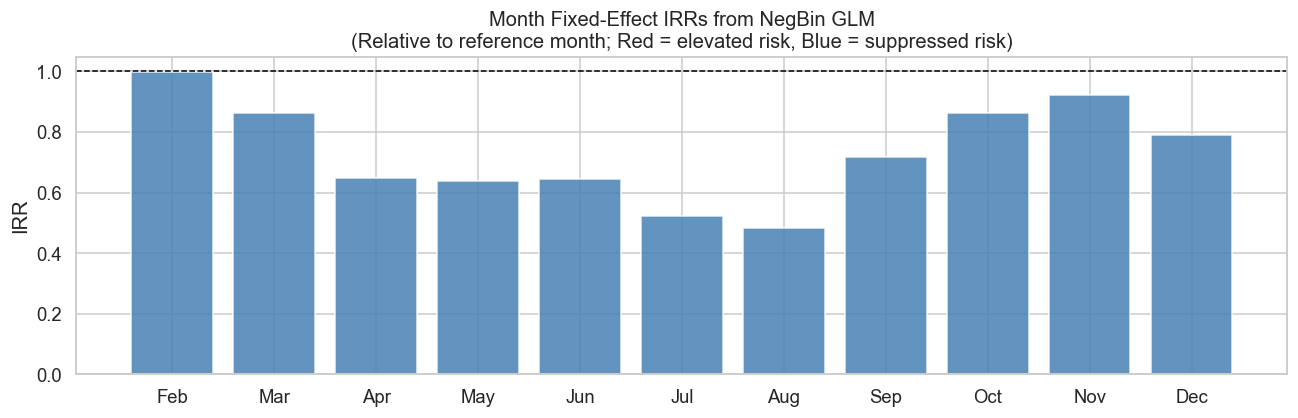

Month IRR summary (GLM estimated vs raw seasonal index):


,GLM_IRR,Raw_Seasonal_Index
month_name,,
Feb,0.998,1.274
Mar,0.862,1.162
Apr,0.647,0.873
May,0.639,0.857
Jun,0.645,0.830
Jul,0.523,0.615
Aug,0.484,0.583
Sep,0.718,0.995
Oct,0.861,1.239


In [52]:
# Extract and plot month coefficients from the seasonal model
month_coefs = (
    pd.DataFrame({'coef': glm_nb.params, 'p': glm_nb.pvalues})
      .reset_index()
      .rename(columns={'index':'term'})
      .query('term.str.contains("treatment_month")', engine='python')
)
month_coefs['IRR']   = np.exp(month_coefs['coef'])
month_coefs['month'] = month_coefs['term'].str.extract(r'(\d+)').astype(int)
month_coefs = month_coefs.sort_values('month')

fig, ax = plt.subplots(figsize=(12, 4))
bar_c = ['firebrick' if v > 1 else 'steelblue' for v in month_coefs['IRR']]
ax.bar(month_coefs['month'], month_coefs['IRR'], color=bar_c, alpha=0.85)
ax.axhline(1, color='black', linestyle='--', linewidth=1)
ax.set_xticks(month_coefs['month'])
ax.set_xticklabels([month_names[m-1] for m in month_coefs['month']])
ax.set_title('Month Fixed-Effect IRRs from NegBin GLM\n'
             '(Relative to reference month; Red = elevated risk, Blue = suppressed risk)')
ax.set_ylabel('IRR')
plt.tight_layout(); plt.show()

print('Month IRR summary (GLM estimated vs raw seasonal index):')
merged = (
    month_coefs[['month','IRR']]
    .merge(season_idx[['seasonal_idx']].reset_index().rename(columns={'treatment_month':'month'}),
           on='month')
    .rename(columns={'IRR':'GLM_IRR', 'seasonal_idx':'Raw_Seasonal_Index'})
)
merged['month_name'] = [month_names[m-1] for m in merged['month']]
display(merged.set_index('month_name').round(3).drop(columns='month'))

> **Month IRR vs raw seasonal index**
> The table compares:
> - **GLM_IRR**: the month effect estimated *jointly* with all other risk factors
>   (age, gender, nationality etc.) — these are *adjusted* seasonal effects.
> - **Raw_Seasonal_Index**: the naive month / annual-average rate ratio from
>   the raw data — unadjusted for portfolio composition changes across months.
>
> When the two columns are close, portfolio composition is stable across months
> and the raw index is a sufficient approximation.
> Large divergences indicate that the member mix changes seasonally
> (e.g., seasonal worker population), making the GLM adjustment important.